# **Loan Default Prediction**

## **Problem Definition**

### **The Context:**

Preventing defaults ensures that the banking system remains solvent and capable of supporting economic growth. Since the most of the profit derives  from loan interests, the banking system requires a systematic approach for loan approval.

### **The objective:**

 - The main objective of this project is to understand the aggravating factors of loan default by deploying a variety of machine learning models and other data-driven approaches. The confidence of the models as well as the analysis prior deployment is of outmost importance for decicion making.

### **The key questions:**

- Which are the driving forces of loan default in this dataset.
- If we identify them, aside from prediction value, do they also offer some insight of what kind of individual profiles lean towards loan default.
- Is there a specific profile or are there many.
- Are we even able to profile them? <br>
### **The problem formulation**:
- Can we identify hallmarks of loan default?
- Could we diagnose early the loan-defaulters?
- Is the group of these defaulters homogenous, or maybe a series of different circumstances may lead to this outcome.
- Do all loan-defaulters share same traits, of course, based on the data we can access.
- Usng these banking records, can we locate sources of incongruency abd suggest more efficient methods of data handling or client treatment?

## **Data Description:**
The Home Equity dataset (HMEQ) contains baseline and loan performance information for 5,960 recent home equity loans. The target (BAD) is a binary variable that indicates whether an applicant has ultimately defaulted or has been severely delinquent. This adverse outcome occurred in 1,189 cases (20 percent). 12 input variables were registered for each applicant.


* **BAD:** 1 = Client defaulted on loan, 0 = loan repaid

* **LOAN:** Amount of loan approved.

* **MORTDUE:** Amount due on the existing mortgage.

* **VALUE:** Current value of the property.

* **REASON:** Reason for the loan request. (HomeImp = home improvement, DebtCon= debt consolidation which means taking out a new loan to pay off other liabilities and consumer debts)

* **JOB:** The type of job that loan applicant has such as manager, self, etc.

* **YOJ:** Years at present job.

* **DEROG:** Number of major derogatory reports (which indicates a serious delinquency or late payments).

* **DELINQ:** Number of delinquent credit lines (a line of credit becomes delinquent when a borrower does not make the minimum required payments 30 to 60 days past the day on which the payments were due).

* **CLAGE:** Age of the oldest credit line in months.

* **NINQ:** Number of recent credit inquiries.

* **CLNO:** Number of existing credit lines.

* **DEBTINC:** Debt-to-income ratio (all your monthly debt payments divided by your gross monthly income. This number is one way lenders measure your ability to manage the monthly payments to repay the money you plan to borrow.

## **Import the necessary libraries and Data**

In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import umap

import warnings
warnings.filterwarnings("ignore")

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression


# Metrics to evaluate the model, precision recall-curve too
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, make_scorer
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.inspection import permutation_importance


# Hyperparameter tuning
# For tuning the model
from sklearn.model_selection import GridSearchCV

# For plots arrangement
plt.rcParams['axes.spines.top'] = False    # Remove top border
plt.rcParams['axes.spines.right'] = False  # Remove right border

# pip install dash
!pip install dash


## **Data Overview**

- Reading the dataset
- Understanding the shape of the dataset
- Checking the data types
- Checking for missing values
- Checking for duplicated values

In [288]:
# load data from colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [289]:
data_raw = pd.read_csv("/content/drive/MyDrive/colab_mit/data/hmeq.csv")
df = data_raw.copy()

In [290]:
  # I found this very interesting code and i made some addtions
  # Identify missingness and duplications
  print(f"Data has dimension of {df.shape}")
  miss_ = df.isnull().sum()[df.isnull().sum() > 0]
  percentage = (miss_ / df.shape[0]) * 100

  print(miss_.shape[0], 'columns has missing values')
  print('-'*50)
  print(pd.DataFrame({'Count':miss_, 'Percentage %':percentage}))
  print(f"Duplicated entries: {df.duplicated().sum()}")
  mask1 = df.isna().sum(axis=1)>0
  mask2 = df.isna().sum(axis=1)>1
  print(f"Entries with more than 0 of missing values across features: {df[mask1].index.nunique()} of total {df.shape[0]}")
  print(f"Entries with more than 1 of missing values across features: {df[mask2].index.nunique()} of total {df.shape[0]}")

Data has dimension of (5960, 13)
11 columns has missing values
--------------------------------------------------
         Count  Percentage %
MORTDUE    518      8.691275
VALUE      112      1.879195
REASON     252      4.228188
JOB        279      4.681208
YOJ        515      8.640940
DEROG      708     11.879195
DELINQ     580      9.731544
CLAGE      308      5.167785
NINQ       510      8.557047
CLNO       222      3.724832
DEBTINC   1267     21.258389
Duplicated entries: 0
Entries with more than 0 of missing values across features: 2596 of total 5960
Entries with more than 1 of missing values across features: 1007 of total 5960


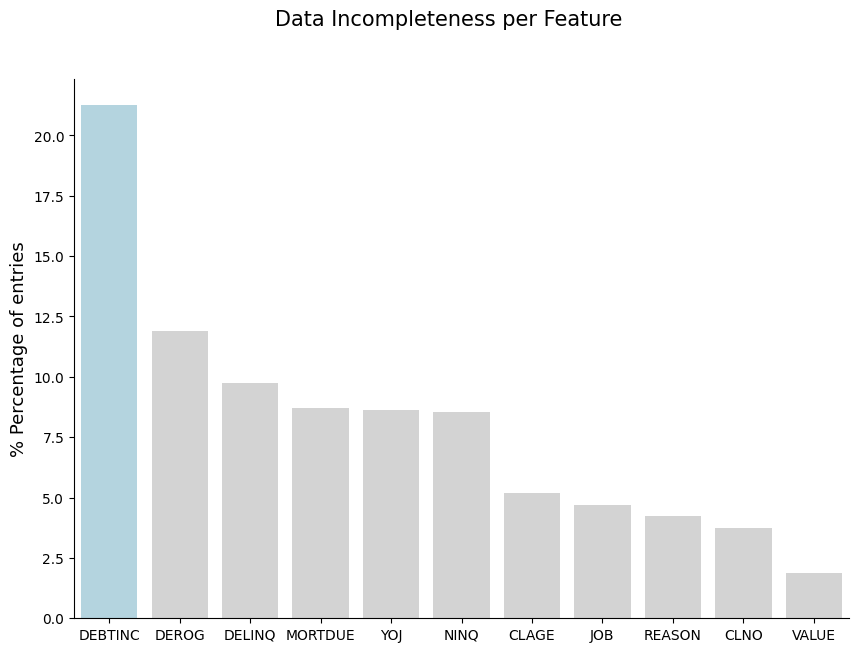

In [291]:
# make a barplot with percentage of missing values percentage df
fig, ax = plt.subplots(figsize=(10,7))
perc = pd.DataFrame(percentage, columns=["Percentage"]).sort_values(by="Percentage", ascending=False)

# set all the values to gray except the DEBTINC
color_map =  ["lightblue" if x == "DEBTINC" else "lightgray" for x in perc.index]
sns.barplot(pd.DataFrame(percentage, columns=["Percentage"]).sort_values(by="Percentage", ascending=False).T,
            palette = color_map, ax=ax)

ax.set_ylabel("% Percentage of entries", fontsize=13)
plt.suptitle("Data Incompleteness per Feature", fontsize=15)

# save in hogh quality
plt.savefig("data_incompleteness.png", dpi=600)
plt.show()



In [292]:
data_raw.isna().sum().sum(), data_raw.size

(np.int64(5271), 77480)

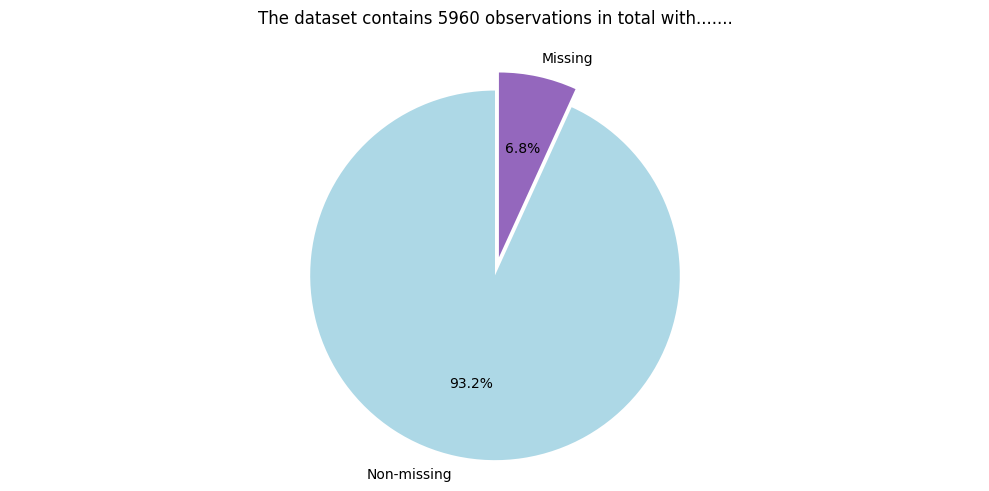

In [293]:
# 1) Compute totals
total = data_raw.size
missing = data_raw.isnull().sum().sum()
non_missing = total - missing

# 2) Prepare pie chart parameters
labels = ['Non‑missing', 'Missing']
counts = [non_missing, missing]
# Explode the smaller slice (usually “Missing”)
explode = [0, 0.1] if missing <= non_missing else [0.1, 0]
colors = ['lightblue', 'tab:purple']

# 3) Draw the pie
plt.figure(figsize=(10, 5))
plt.pie(
    counts,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    explode=explode,
    wedgeprops=dict(edgecolor='none')  # no borders
)
plt.title(f"The dataset contains {data_raw.shape[0]} observations in total with.......", y =1.05)
plt.axis('equal')   # keep as circle
plt.tight_layout()
plt.show()

# 4) Print the exact percentage
pct_missing = missing / total * 100


In [294]:
# Missing values vs Total pie chart


In [295]:
df.nunique()

,0
BAD,2
LOAN,540
MORTDUE,5053
VALUE,5381
REASON,2
JOB,6
YOJ,99
DEROG,11
DELINQ,14
CLAGE,5314


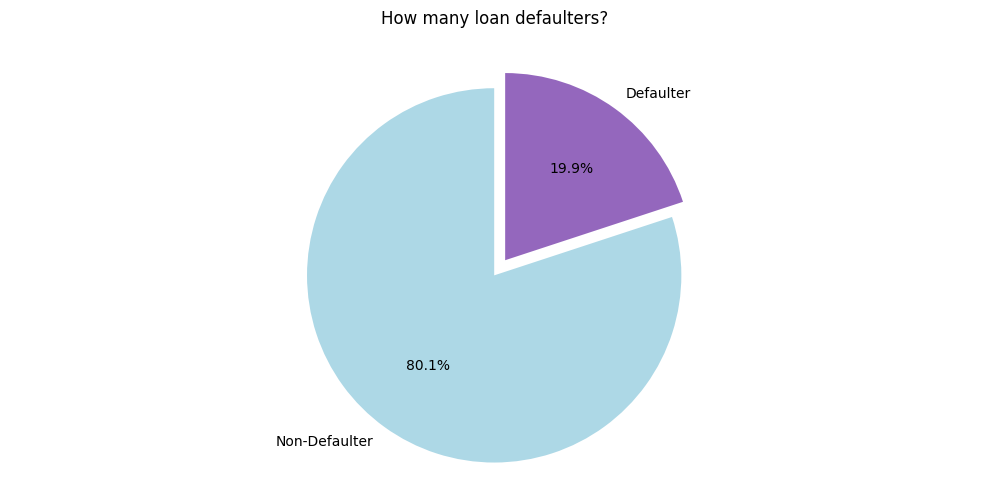

Percentage of defaulters: 19.950%


In [296]:
# count by class
bad_counts = df['BAD'].value_counts()

# map 0 and 1 to meaningful labels, in the same order as bad_counts.index
labels = ['Non‑Defaulter' if x == 0 else 'Defaulter' for x in bad_counts.index]

# explode only the smaller slice (assumed to be defaulters)
# find which position is the 'Defaulter' in our labels list
explode = [0.1 if lab == 'Defaulter' else 0 for lab in labels]

plt.figure(figsize=(10, 5))
plt.pie(
    bad_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'tab:purple'],
    explode=explode
)
plt.title("How many loan defaulters?",y=1.05)
plt.axis('equal')  # ensures pie is drawn as a circle
plt.tight_layout()
plt.show()

# cleaner percentage calc
pct_defaulters = df['BAD'].mean() * 100
print(f"Percentage of defaulters: {pct_defaulters:.3f}%")

## Summary Statistics

In [297]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).columns
numeric_features = numeric_features.drop("BAD")
df[numeric_features].describe().T

,count,mean,std,min,25%,50%,75%,max
LOAN,5960.0,18607.969799,11207.480417,1100.000000,11100.000000,16300.000000,23300.000000,89900.000000
MORTDUE,5442.0,73760.817200,44457.609458,2063.000000,46276.000000,65019.000000,91488.000000,399550.000000
VALUE,5848.0,101776.048741,57385.775334,8000.000000,66075.500000,89235.500000,119824.250000,855909.000000
YOJ,5445.0,8.922268,7.573982,0.000000,3.000000,7.000000,13.000000,41.000000
DEROG,5252.0,0.254570,0.846047,0.000000,0.000000,0.000000,0.000000,10.000000
DELINQ,5380.0,0.449442,1.127266,0.000000,0.000000,0.000000,0.000000,15.000000
CLAGE,5652.0,179.766275,85.810092,0.000000,115.116702,173.466667,231.562278,1168.233561
NINQ,5450.0,1.186055,1.728675,0.000000,0.000000,1.000000,2.000000,17.000000
CLNO,5738.0,21.296096,10.138933,0.000000,15.000000,20.000000,26.000000,71.000000
DEBTINC,4693.0,33.779915,8.601746,0.524499,29.140031,34.818262,39.003141,203.312149


In [298]:
categ_features = df.select_dtypes(include=['object']).columns


# Unique categires  and their values per feature
for col in categ_features:
    df[col] = df[col].astype('category')
    print(df[col].value_counts())
    print("-" * 50)
    print("\n")

# put BAD into categorical features
categ_features = np.append(categ_features, "BAD")

REASON
DebtCon    3928
HomeImp    1780
Name: count, dtype: int64
--------------------------------------------------


JOB
Other      2388
ProfExe    1276
Office      948
Mgr         767
Self        193
Sales       109
Name: count, dtype: int64
--------------------------------------------------




In [299]:
df.describe(include="category").T

,count,unique,top,freq
REASON,5708,2,DebtCon,3928
JOB,5681,6,Other,2388


- Observations from Summary Statistics
- The numerical features have outliers as the max/min values are quite far from the mean and medians. Furthermore I observe variation in some features, where they show considerably high standard deviation. These are: LOAN, MORTDUE,VALUE, YOJ, CLAGE, CLNO, DEBTINC

## **Exploratory Data Analysis (EDA) and Visualization**

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you approach the analysis in the right manner and generate insights from the data.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

**Leading Questions**:
1. What is the range of values for the loan amount variable "LOAN"?
2. How does the distribution of years at present job "YOJ" vary across the dataset?
3. How many unique categories are there in the REASON variable?
4. What is the most common category in the JOB variable?
5. Is there a relationship between the REASON variable and the proportion of applicants who defaulted on their loan?
6. Do applicants who default have a significantly different loan amount compared to those who repay their loan?
7. Is there a correlation between the value of the property and the loan default rate?
8. Do applicants who default have a significantly different mortgage amount compared to those who repay their loan?

### **Univariate, Bivariate & Multivariate Analysis**

#### Numerical Features

In [300]:
# Function to use for combined Univariate and bivariate analysis

def combined_hist_boxplot(data, feature, hue_choice = "BAD", figsize=(12, 7), bins=None):
  # make custom pallete for hue
  if hue_choice == "BAD":
    custom_palette = {0: "lightgray", 1: "gold"}
  else:
    custom_palette = "Set2"
  fig = plt.figure(figsize=figsize)
  gs = fig.add_gridspec(2, 2, width_ratios=(3, 1), height_ratios=(1, 1),
                          wspace=0.3, hspace=0.3)

  # Left column: top subplot for the violin plot
  ax_box2 = fig.add_subplot(gs[0, 0])
  sns.violinplot(
      data=data,
      x=feature,
      ax=ax_box2,
      palette={0: "lightgray", 1: "gold"},
      hue="BAD",
      split=True,
      alpha=0.5,
      gap=.1
  )
  ax_box2.set_xlabel("")
  ax_box2.set_ylabel("")
  # ax_box2.legend(title = "Default", frameon=False, bbox_to_anchor=(1, 1.1))

  # do not show figure legend
  ax_box2.get_legend().remove()

  # Left column: bottom subplot for the histogram and KDE plot
  ax_hist2 = fig.add_subplot(gs[1, 0])
  if bins:
      sns.histplot(
          data=data,
          x=feature,
          ax=ax_hist2,
          bins=bins,
          color="darkblue",
          alpha=0.4
      )
  else:
      sns.histplot(
          data=data,
          x=feature,
          ax=ax_hist2,
          color="darkblue",
          alpha=0.4
      )
  # Add a twin y-axis to overlay the KDE
  ax_hist2twin = ax_hist2.twinx()
  sns.kdeplot(
      data=data,
      x=feature,
      ax=ax_hist2twin,
      color="black",
      shade=True,
      fill=False,
      alpha=0.05
  )
  # do not show the second y axis values
  ax_hist2twin.set_yticks([])
  ax_hist2twin.set_ylabel("")
  # Add mean and median vertical lines on the histogram
  ax_hist2.axvline(
      data[feature].mean(), color="green", linestyle="--"
  )
  ax_hist2.axvline(
      data[feature].median(), color="black", linestyle="-"
  )


  # Right column
  ax_box_right = fig.add_subplot(gs[:, 1])

  # make custom pallete for hue
  if hue_choice == "BAD":
    custom_palette = {0: "lightgray", 1: "gold"}
  else:
    custom_palette = "Set2"


  sns.boxplot(
      data=data,
      y=feature,
      ax=ax_box_right,
      hue=hue_choice,
      palette=custom_palette     # optional: use a palette of your choice
  )
  # adjust figure legend horizontally
  leg = ax_box_right.legend(frameon=False, bbox_to_anchor=(0.9,-0.05),
                      ncols=2, fontsize = 13)
  # increase the fontsize of the figure legend title
  ax_box_right.get_legend().set_title("Default")
  leg.get_title().set_fontsize(13)

  ax_box_right.set_title(f"Boxplot of {feature}")

  # Set a super title for the figure and adjust layout
  fig.suptitle(f"Effect of {feature} to Loan Defaults", fontsize=16)
  plt.tight_layout(rect=[0, 0, 0.5, 0.95])

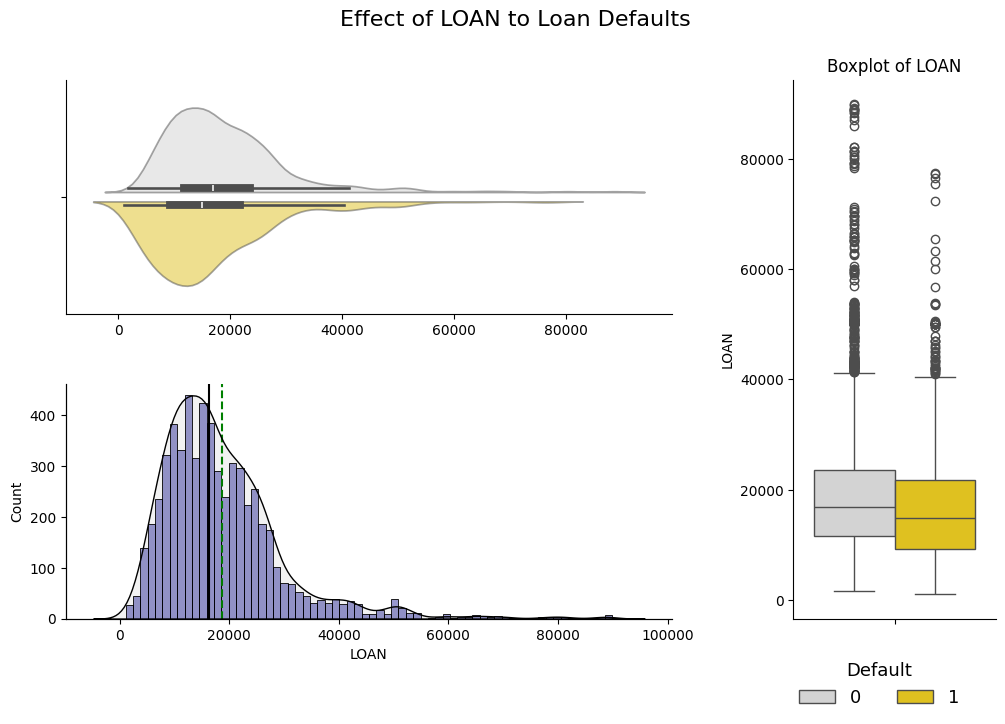

----------------------------------------------------------------------------------------------------------------------------------------------------------------




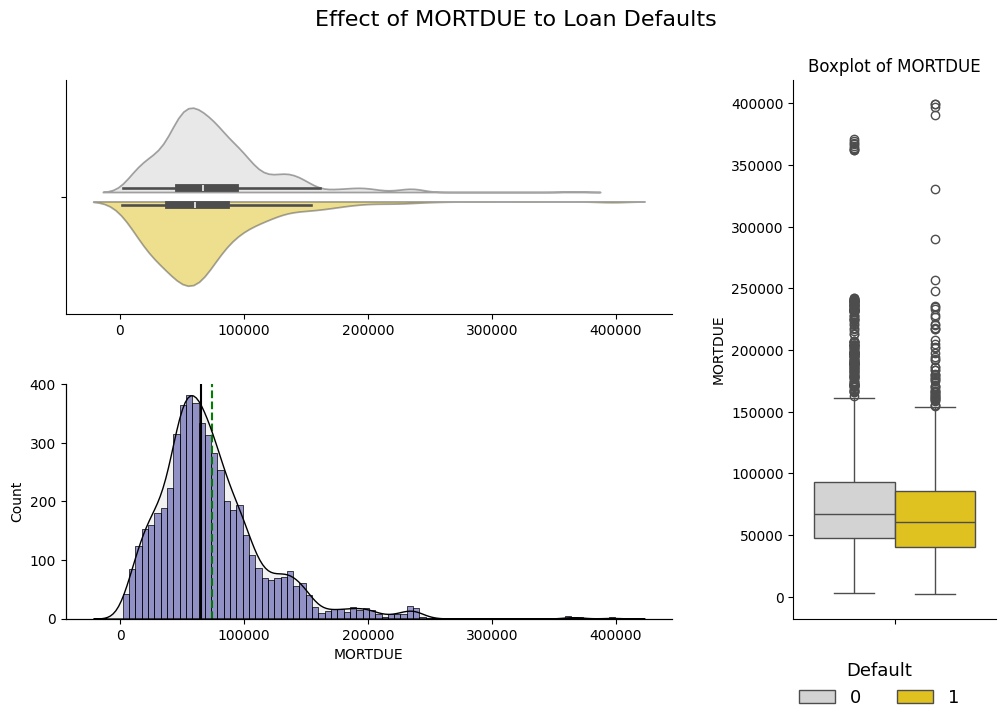

----------------------------------------------------------------------------------------------------------------------------------------------------------------




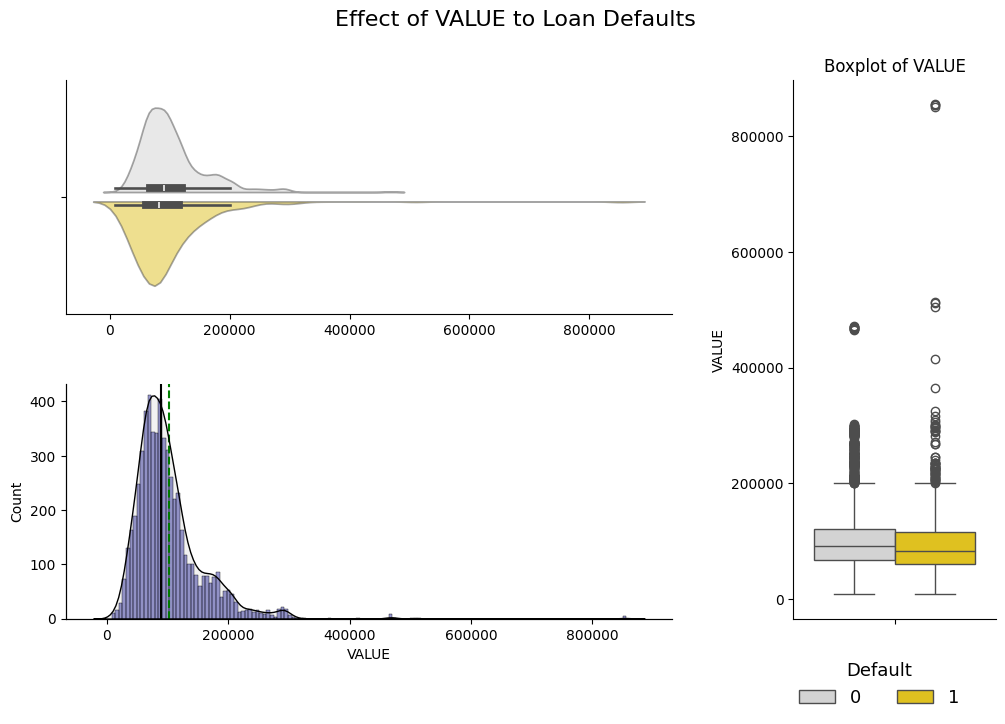

----------------------------------------------------------------------------------------------------------------------------------------------------------------




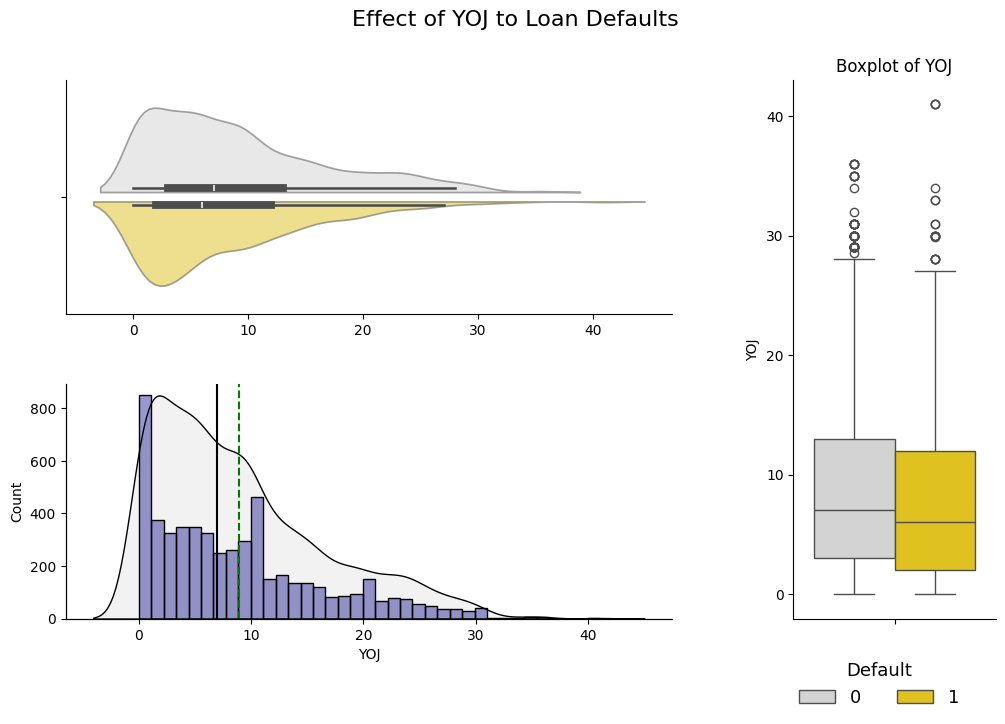

----------------------------------------------------------------------------------------------------------------------------------------------------------------




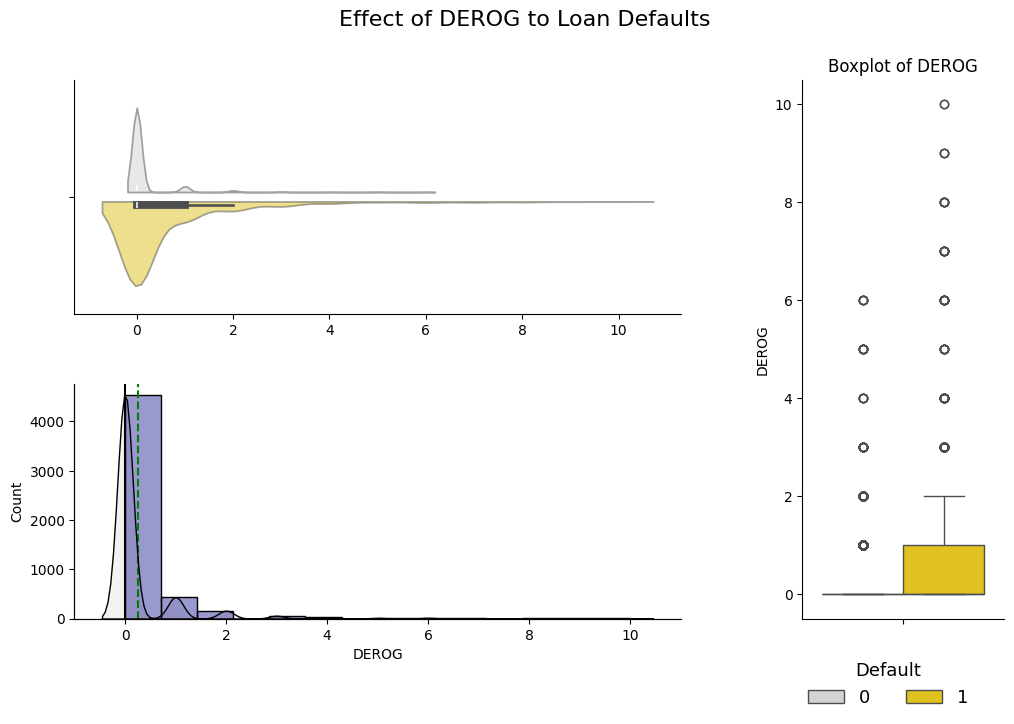

----------------------------------------------------------------------------------------------------------------------------------------------------------------




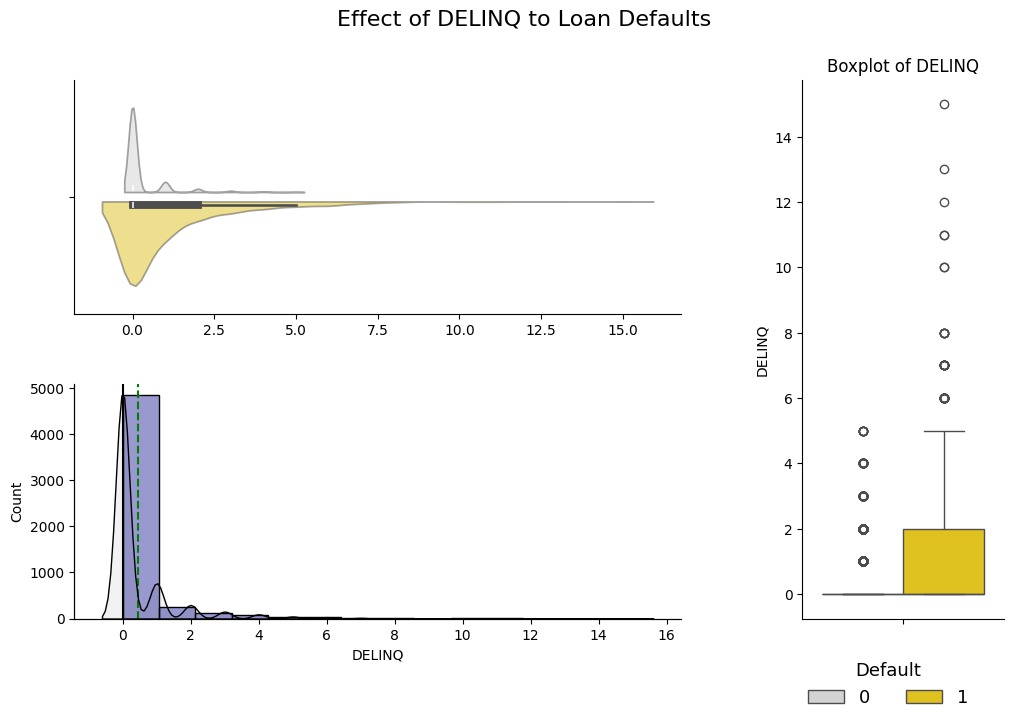

----------------------------------------------------------------------------------------------------------------------------------------------------------------




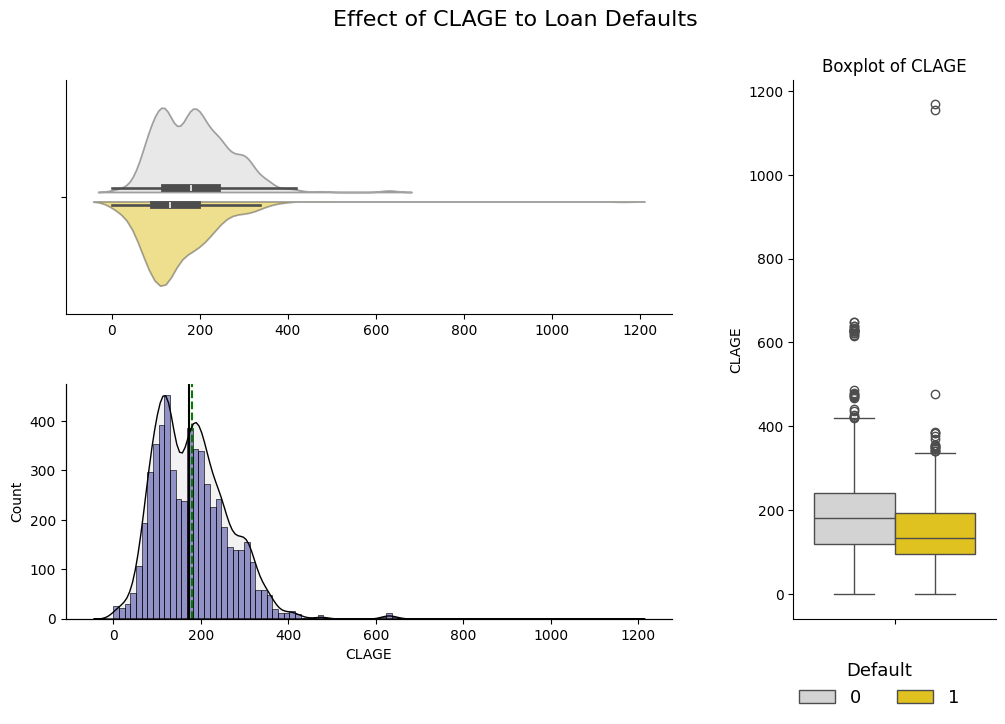

----------------------------------------------------------------------------------------------------------------------------------------------------------------




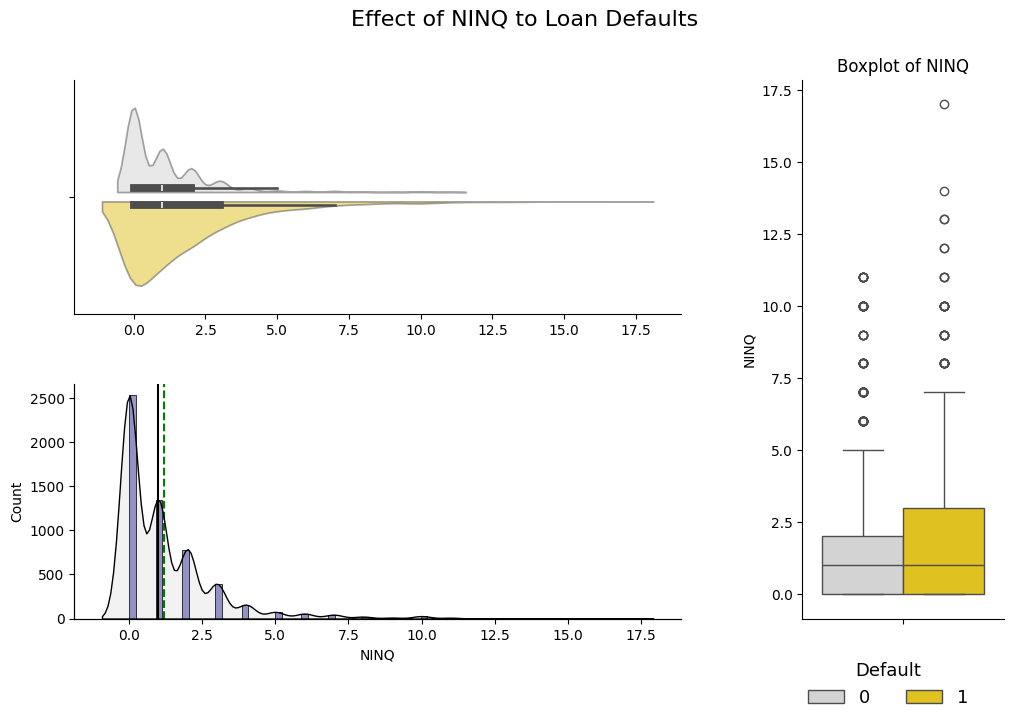

----------------------------------------------------------------------------------------------------------------------------------------------------------------




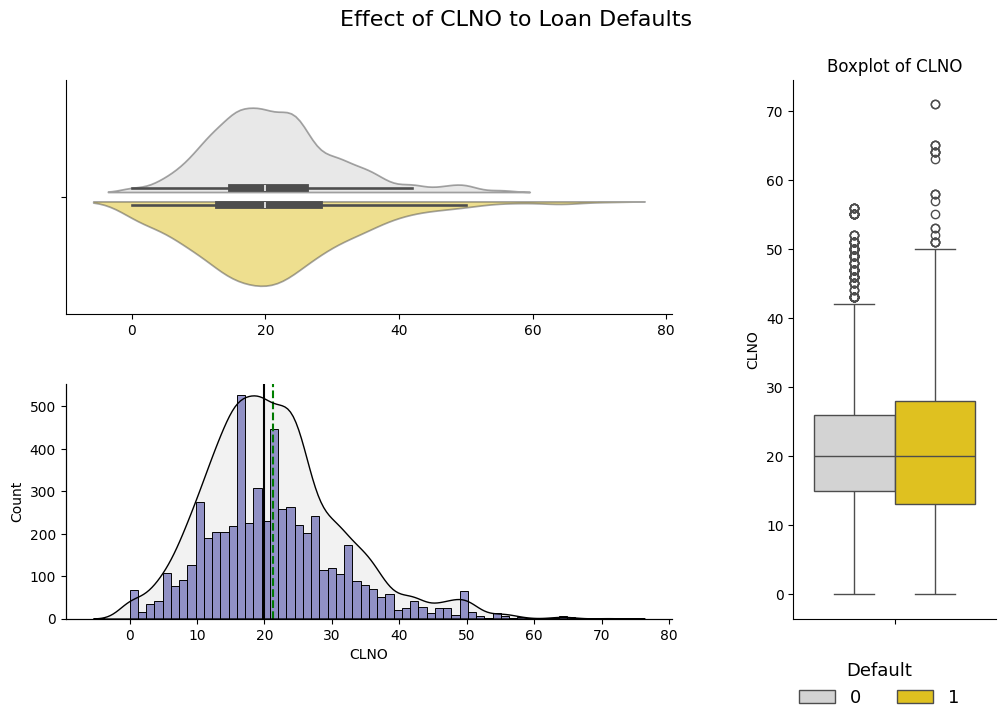

----------------------------------------------------------------------------------------------------------------------------------------------------------------




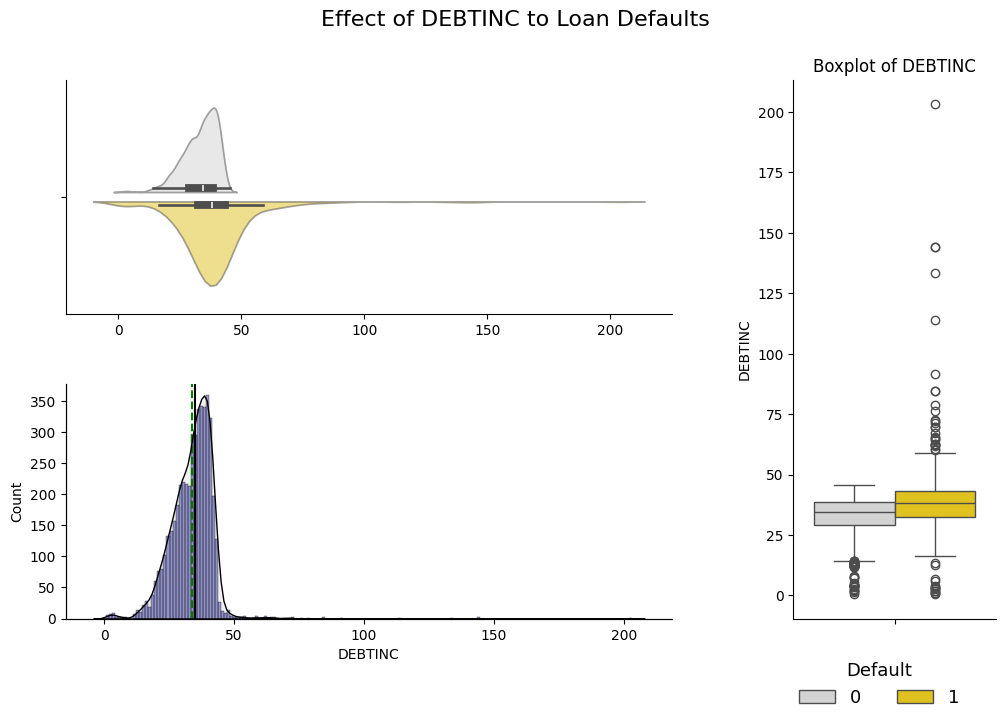

----------------------------------------------------------------------------------------------------------------------------------------------------------------




In [301]:
for feat in numeric_features:
  if feat == "BAD":
    continue
  # print(feat)
  combined_hist_boxplot(df, feat, hue_choice = "BAD", figsize=(12, 7), bins=None)
  plt.show()
  print("--------"*20)
  print("\n")

<Axes: >

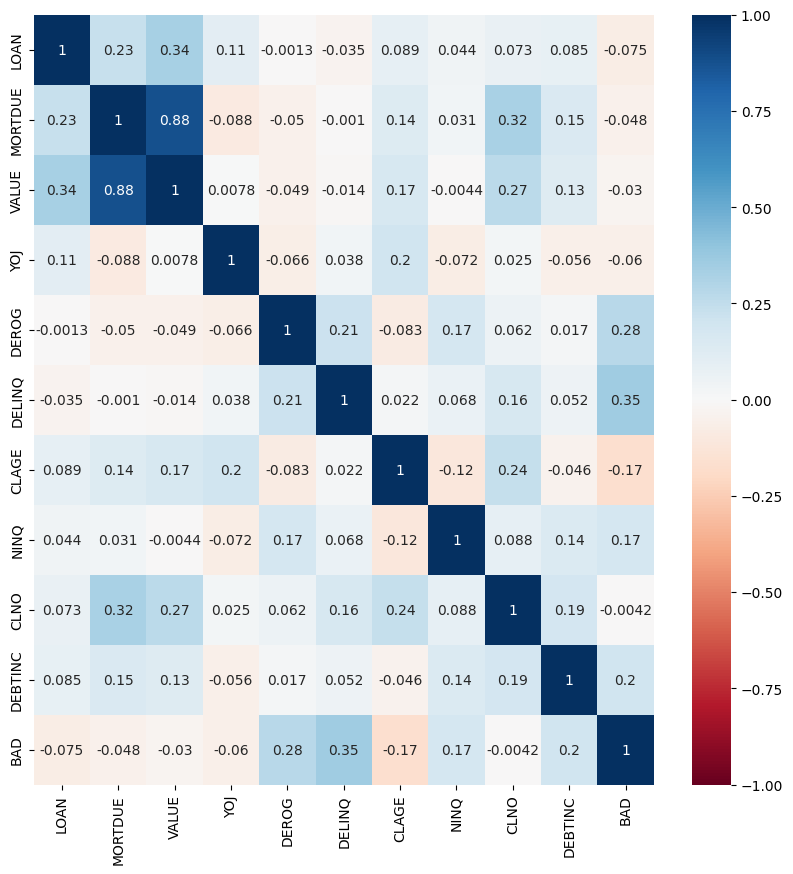

In [302]:
# Multicariate analysis of the numerical data
# correlation analysis and visualization
plt.figure(figsize=(10,10))
# sns.heatmap(data[num_cols].corr(), annot=True, cmap="coolwarm")
sns.heatmap(pd.concat([df[numeric_features], df['BAD']],axis=1).corr(), annot=True, cmap="RdBu", vmin=-1,
            vmax=1)

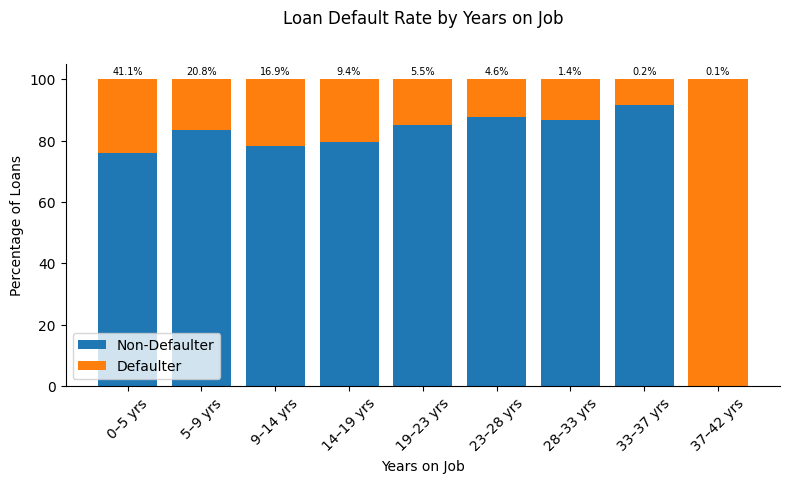

In [303]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# bins and labels - cut
bins = np.linspace(0, df['YOJ'].max() + 1, 10).round(0).tolist()
labels = [f"{int(bins[i])}–{int(bins[i+1])} yrs" for i in range(len(bins) - 1)]

df['YOJ_bin'] = pd.cut(df['YOJ'], bins=bins, labels=labels, include_lowest=True)

# Compute % defaulters
grouped = (
    df
    .groupby('YOJ_bin')['BAD']
    .value_counts(normalize=True)
    .unstack(fill_value=0)
    * 100
)

# 4) Compute % of *all* obs in each bin
obs_pct = df['YOJ_bin'].value_counts(normalize=True).reindex(labels) * 100

# 5) Plot stacked bars
fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(labels))
bottom = np.zeros(len(labels))

for bad_flag, name in [(0, 'Non‑Defaulter'), (1, 'Defaulter')]:
    heights = grouped[bad_flag].values
    ax.bar(x, heights, bottom=bottom, label=name)
    bottom += heights

# 6) Annotate overall-% above each bar
for i, pct in enumerate(obs_pct.values):
    ax.text(i, 100 + 1, f"{pct:.1f}%", ha='center', va='bottom', fontsize=7)

# 7) Final styling
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.set_xlabel('Years on Job')
ax.set_ylabel('Percentage of Loans')
ax.set_title('Loan Default Rate by Years on Job', y=1.1)
ax.legend(title='')
plt.tight_layout()
plt.show()

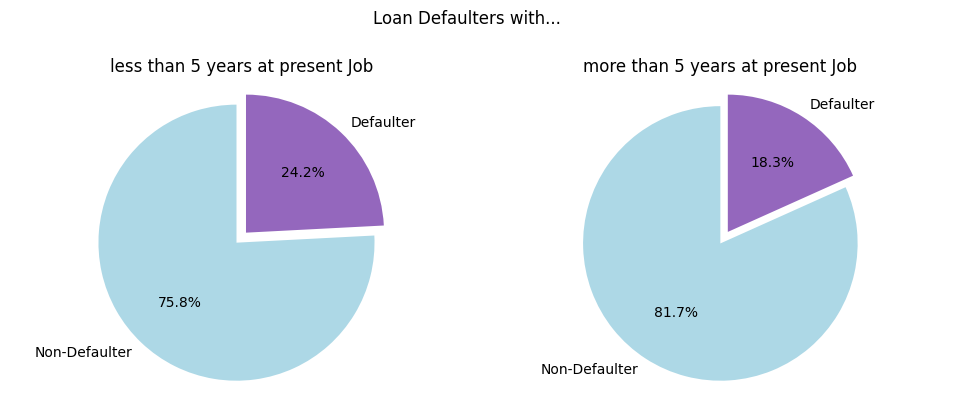

In [304]:
# map 0 and 1 to meaningful labels, in the same order as bad_counts.index
thres = 5
# explode only the smaller slice (assumed to be defaulters)
# find which position is the 'Defaulter' in our labels list


# make two subplots for those below 5 years of employment and above 5 years of employment
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
labels = ['Non‑Defaulter' if x == 0 else 'Defaulter' for x in df[df["YOJ"] < thres ]["BAD"].value_counts().index]
explode = [0.1 if lab == 'Defaulter' else 0 for lab in labels]

plt.pie(
    df[df["YOJ"] < thres ]["BAD"].value_counts().values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'tab:purple'],
    explode=explode
)
plt.title(f'less than {thres} years at present Job')
plt.axis('equal')  # ensures pie is drawn as a circle

plt.subplot(1, 2, 2)
labels = ['Non‑Defaulter' if x == 0 else 'Defaulter' for x in df[df["YOJ"] > thres ]["BAD"].value_counts().index]
explode = [0.1 if lab == 'Defaulter' else 0 for lab in labels]

plt.pie(
    df[df["YOJ"] > thres ]["BAD"].value_counts().values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'tab:purple'],
    explode=explode
)
plt.title(f'more than {thres} years at present Job')
plt.axis('equal')  # ensures pie is drawn as a circle
plt.suptitle('Loan Defaulters with...', y=1)
plt.tight_layout()
plt.show()



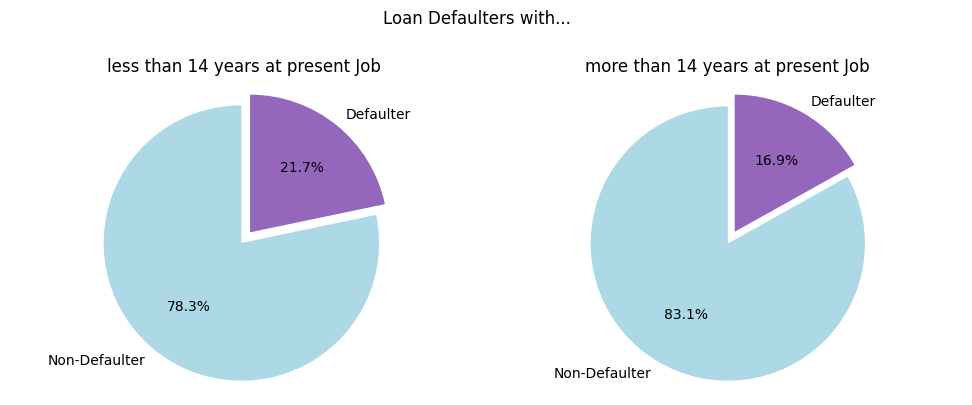

In [305]:
# map 0 and 1 to meaningful labels, in the same order as bad_counts.index
thres = 14
# explode only the smaller slice (assumed to be defaulters)
# find which position is the 'Defaulter' in our labels list


# make two subplots for those below 5 years of employment and above 5 years of employment
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
labels = ['Non‑Defaulter' if x == 0 else 'Defaulter' for x in df[df["YOJ"] < thres ]["BAD"].value_counts().index]
explode = [0.1 if lab == 'Defaulter' else 0 for lab in labels]

plt.pie(
    df[df["YOJ"] < thres ]["BAD"].value_counts().values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'tab:purple'],
    explode=explode
)
plt.title(f'less than {thres} years at present Job')
plt.axis('equal')  # ensures pie is drawn as a circle

plt.subplot(1, 2, 2)
labels = ['Non‑Defaulter' if x == 0 else 'Defaulter' for x in df[df["YOJ"] > thres ]["BAD"].value_counts().index]
explode = [0.1 if lab == 'Defaulter' else 0 for lab in labels]

plt.pie(
    df[df["YOJ"] > thres ]["BAD"].value_counts().values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'tab:purple'],
    explode=explode
)
plt.title(f'more than {thres} years at present Job')
plt.axis('equal')  # ensures pie is drawn as a circle
plt.suptitle('Loan Defaulters with...', y=1)
plt.tight_layout()
plt.show()

### Obseravations - Numerical Features
- LOAN shows a left-skewed distribution with a median around 16300. Most people do not apply loans of high value. VALUE is also following the distribution of LOAN. They contain outliers in both classes making any assumptions from the distributios alone difficult.
- Years at present job has left-skewed distribution with an avergage of 9 years. High number of applicants are observed at 1 year and 10 years of experience. There is small tendency showing that individualls with less years in the job market may have have a higher chance to deafult, however it is not fully pronounced. On the other hand the CLAGE variable shows no correlation with the prediction class.
- MORTDUE is correlated with VALUE, and shows no significant relationship with the prediction class either.
- DEROG and DELIQ show an interesting distribution. Most DEROG values are zero fo the non-defaulters whereas most defaulters are with at least 1 in terms of frequency. However, derogatory marks above 1 are quite rare for non-deafaulters. While it is not safe to assume that someone with no deragatory mark wont default, deragatory marks might be a strong indication for loan default.  The deliquent credit lines also follow the same rational. The more the increase the higher the chance of loan default. There is also a moderate correlation between the class variable.
- As for debt-to-income ration, the higher the ratio the higher the chance to default the loan (DEBTINC).
- 'DEBTINC, 'LOAN', 'MORTDUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ' have outliers, but some of them only in the positive class. This might mean something. I will be using either the IQR method or I will define my own threshold for outlier treatment depending on the positive class labels.


#### Categorical Features

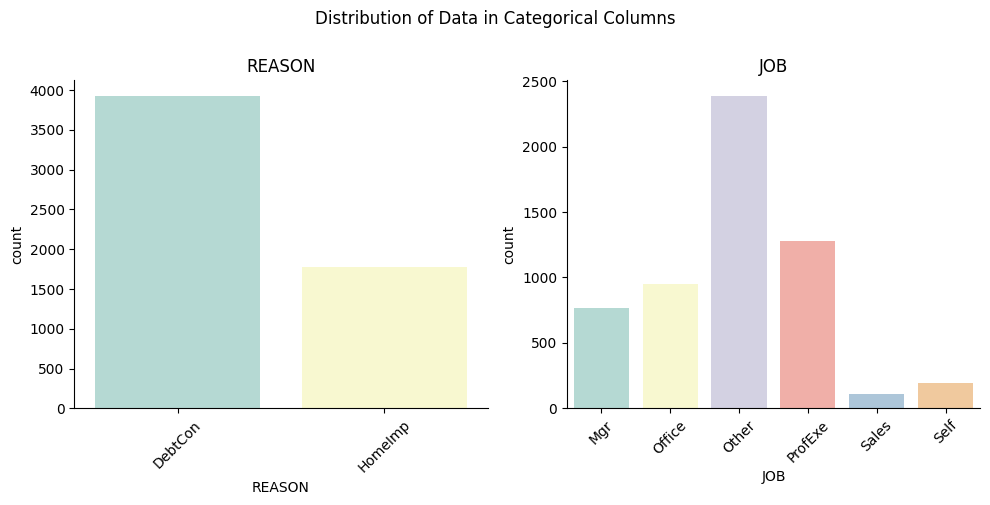

In [306]:
# Plotting distribution of categorical data

plt.figure(figsize=(10, 5))
for i, col in enumerate(categ_features, 1):
  if col == "BAD":
    continue

  plt.subplot(1,2, i)
  sns.countplot(data=df, x=col, color="gray", palette="Set3", alpha=0.7)
  plt.xticks(rotation=45)
  plt.title(col)
  plt.suptitle("Distribution of Data in Categorical Columns", y=1)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

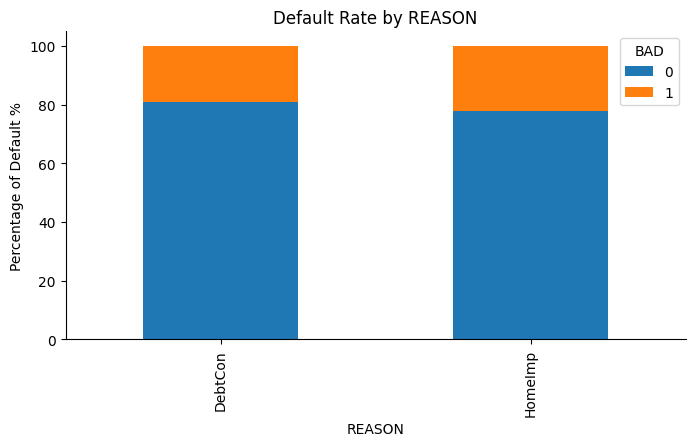

------------------------------------------------------------------------------------------------------------------------------------------------------




<Figure size 1000x600 with 0 Axes>

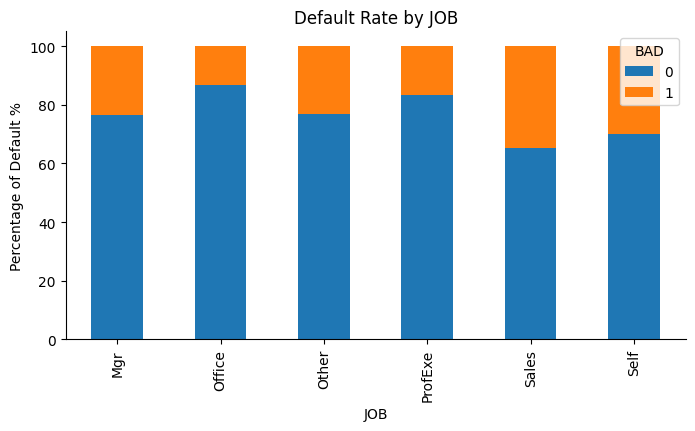

------------------------------------------------------------------------------------------------------------------------------------------------------




In [307]:
for col in categ_features:
  if col == "BAD":
    continue
  plt.figure(figsize=(10, 6))
  (pd.crosstab(df[col], df["BAD"], normalize = 'index')*100).plot(kind = 'bar', figsize = (8, 4), stacked = True)
  plt.title(f"Default Rate by {col}")
  plt.ylabel('Percentage of Default %')
  plt.show()
  print("---" * 50)
  print("\n")

- The reason of loan has no relationship with its default.
- Self-eployed and sales professionals defaulted more frequently than individualls with other professions.
- Other category contains many observations and maybe should be stratidied more into newer categories.

## Treating Missing Values and Outliers
- I decided not to use the IQR method becaue I am going to lose many observations of the positive class.
- I wil put higher thresholds that the one using the IQR.
- First I will deal with the missing values since subsetting for outliers will drop entries with NAs
- As shown below, keeping entries with at most one missing values in numerical features preserves some sort of balance between the two classes. We are not losing many observations of the positive class. Since the distribution of most data is skewed, I will perform median imputation, whereas for categorical values I will perform mode imputation.


In [308]:
print(f"Entries with more than 0 of missing values across features: {df[mask1].index.nunique()} of total {df.shape[0]}")
print(f"Entries with more than 1 of missing values across features: {df[mask2].index.nunique()} of total {df.shape[0]}")

Entries with more than 0 of missing values across features: 2596 of total 5960
Entries with more than 1 of missing values across features: 1007 of total 5960


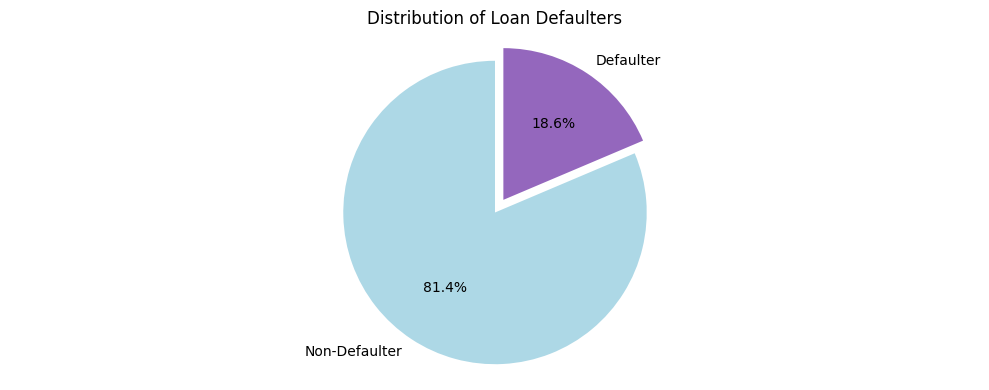

Percentage of defaulters: 18.618%
Number of observations in total: 5022


In [309]:
# keep maximum one NA from the numerical features in
numeric_df = df.select_dtypes(include=['int64', 'float64'])
numeric_df = numeric_df.loc[~(numeric_df.isna().sum(axis=1)>1),:]

# count by class
bad_counts = numeric_df['BAD'].value_counts()

# map 0 and 1 to meaningful labels, in the same order as bad_counts.index
labels = ['Non‑Defaulter' if x == 0 else 'Defaulter' for x in bad_counts.index]

# find which position is the 'Defaulter' in our labels list
explode = [0.1 if lab == 'Defaulter' else 0 for lab in labels]



plt.figure(figsize=(10, 4))
plt.pie(
    bad_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'tab:purple'],
    explode=explode
)
plt.title('Distribution of Loan Defaulters')
plt.axis('equal')  # ensures pie is drawn as a circle
plt.tight_layout()
plt.show()

# cleaner percentage calc
pct_defaulters = numeric_df['BAD'].mean() * 100
print(f"Percentage of defaulters: {pct_defaulters:.3f}%")
print(f"Number of observations in total: {numeric_df.shape[0]}")


In [310]:
# make a final_df  with the index of numeric_df which is cleared for NA > 1
final_df = df.loc[numeric_df.index,:].copy()

# Impute categorical columns with mode
for col in categ_features:
  if col == "BAD":
    continue
  final_df.loc[:, col] = final_df[col].fillna(final_df[col].mode().iat[0])

# Impute numerical columns with median
for col in numeric_features:
  if col == "BAD":
    continue
  final_df.loc[:, col] = final_df[col].fillna(final_df[col].median())

final_df.drop("YOJ_bin", axis=1, inplace=True)

In [311]:
final_df.isna().sum()

,0
BAD,0
LOAN,0
MORTDUE,0
VALUE,0
REASON,0
JOB,0
YOJ,0
DEROG,0
DELINQ,0
CLAGE,0


In [312]:
(final_df["DEBTINC"] < 100).sum()

np.int64(5017)

In [313]:

final_dfc = final_df[
    (final_df['LOAN']   <=  80000) &
    (final_df['MORTDUE']<= 350000) &
    (final_df['VALUE']  <= 400000) &
    (final_df["DEBTINC"] < 80)
]


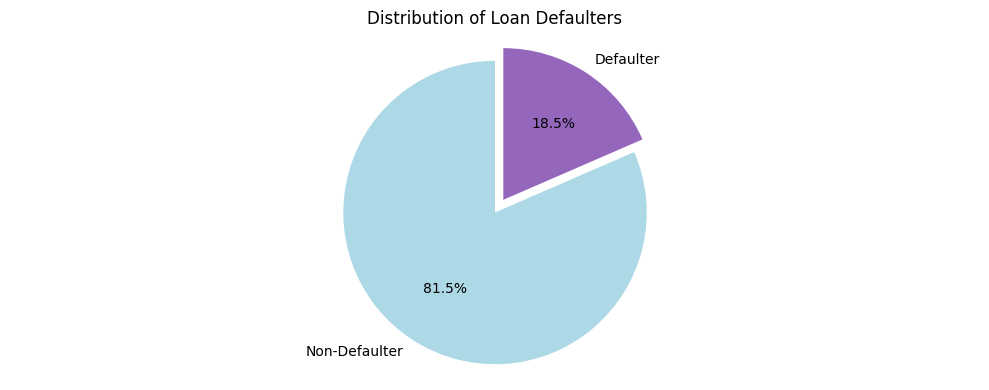

Percentage of defaulters: 18.478%
Number of observations in total: 4979


In [314]:
# count by class
bad_counts = final_dfc['BAD'].value_counts()


# map 0 and 1 to meaningful labels, in the same order as bad_counts.index
labels = ['Non‑Defaulter' if x == 0 else 'Defaulter' for x in bad_counts.index]

# explode only the smaller slice (assumed to be defaulters)
# find which position is the 'Defaulter' in our labels list
explode = [0.1 if lab == 'Defaulter' else 0 for lab in labels]



plt.figure(figsize=(10, 4))
plt.pie(
    bad_counts.values,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90,
    colors=['lightblue', 'tab:purple'],
    explode=explode
)
plt.title('Distribution of Loan Defaulters')
plt.axis('equal')  # ensures pie is drawn as a circle
plt.tight_layout()
plt.show()

# cleaner percentage calc
pct_defaulters = final_dfc['BAD'].mean() * 100
print(f"Percentage of defaulters: {pct_defaulters:.3f}%")
print(f"Number of observations in total: {final_dfc.shape[0]}")


## **Important Insights from EDA**

What are the the most important observations and insights from the data based on the EDA performed?

- High DEBTINC, and credit inquiries indicate a bank loan default in many cases.
- DEBTINC has the highest missing values and defines high number of observation in the positive class, this feature might be an issue.
- LOAN and MORTDUE may be collinear since they correlate greatly.

## **Model Building - Approach**
- Data preparation
- Partition the data into train and test set
- Build the model
- Fit on the train data
- Tune the model
- Test the model on test set

In [315]:
# Data preparation - scaling the numerical values and encoding the categorical ones
cat_cols = categ_features.tolist()
cat_cols.remove("BAD")

ml_df = pd.get_dummies(final_dfc, columns = list(cat_cols), drop_first = True)
X = ml_df.drop(columns=["BAD"], axis=1)
y = ml_df["BAD"]

# set seed for reproducubility
seed = 14

# split tarin-test set in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=seed, stratify=y)

In [316]:
def metrics_score(actual, predicted):

    print(classification_report(actual, predicted))

    cm = confusion_matrix(actual, predicted)

    plt.figure(figsize = (8, 5))

    sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels = ['Not converted', 'Converted'], yticklabels = ['Not Converted', 'Converted'])
    plt.ylabel('Actual')

    plt.xlabel('Predicted')

    plt.show()

### Logistic Regression
- I will perform 10-fold cross validation and tune an L2-regression line.
- I am suspicious of multicolinearity, i will perfomg VIF analysis
- I am not going to bother with the metrics of the Train Data at all.
- Everything will be decided on the test set.
- Scaling is applied independently to avoid data leakage


In [317]:
# make a pipeline with Standard scaler and L2 logistic regression for train set and
# then test set
classifier_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(penalty="l2", solver="liblinear", random_state=seed))
    ])

param_grid = {
        'logreg__C': [0.0005,0.005,0.01,0.05,0.1,1,2,5,10]
    }
# create a cv fold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
# recall of positive class
score_test = make_scorer(recall_score, pos_label=1)

grid = GridSearchCV(classifier_pipe, param_grid, cv=cv, scoring=score_test, n_jobs=4, verbose=1)

grid.fit(X_train, y_train)

model_best = grid.best_estimator_
Y_pred1 = model_best.predict(X_test)
print("Linear Classisifier\n",classification_report(y_test, Y_pred1))
Y_predprob1 = model_best.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, Y_predprob1))
print(grid.best_params_)


Fitting 10 folds for each of 9 candidates, totalling 90 fits
Linear Classisifier
               precision    recall  f1-score   support

           0       0.86      0.97      0.91      1218
           1       0.67      0.29      0.40       276

    accuracy                           0.84      1494
   macro avg       0.76      0.63      0.66      1494
weighted avg       0.82      0.84      0.82      1494

0.8158093572261489
{'logreg__C': 2}


In [318]:
# perform Variance inflation factor analysis to check for colinearity

# get numerical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
Xnum = X[num_cols]
vif_series = pd.Series(
    [variance_inflation_factor(Xnum, i) for i in range(Xnum.shape[1])],
    index = Xnum.columns,
    dtype = float)
del Xnum, num_cols

print("VIF Scores: \n\n{}\n".format(vif_series))



VIF Scores: 

LOAN        4.819927
MORTDUE    15.542804
VALUE      19.585149
YOJ         2.570077
DEROG       1.161874
DELINQ      1.217258
CLAGE       5.851084
NINQ        1.601251
CLNO        7.285986
DEBTINC     9.929146
dtype: float64



From the analysis above I know there is a correlation between the VALUE and MORTDUE, so before finding a proper threshold, i will remove one of the two variables in a new X dataframe X_vif

In [319]:
X_vif = ml_df.drop(columns=["BAD", "VALUE"], axis=1)
y = ml_df["BAD"]

# set seed for reproducubility
seed = 14

# split tarin-test set in a stratified manner
X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=0.3, random_state=seed, stratify=y)

classifier_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(penalty="l2", solver="liblinear", random_state=seed, class_weight="balanced"))
    ])

grid = GridSearchCV(classifier_pipe, param_grid, cv=cv, scoring=score_test, n_jobs=4, verbose=1)

grid.fit(X_train, y_train)

l2model_best = grid.best_estimator_
Y_pred1 = l2model_best.predict(X_test)
print("Linear Classisifier\n",classification_report(y_test, Y_pred1))
Y_predprob1 = l2model_best.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, Y_predprob1))
print(grid.best_params_)

Fitting 10 folds for each of 9 candidates, totalling 90 fits
Linear Classisifier
               precision    recall  f1-score   support

           0       0.92      0.72      0.81      1218
           1       0.37      0.73      0.49       276

    accuracy                           0.72      1494
   macro avg       0.64      0.72      0.65      1494
weighted avg       0.82      0.72      0.75      1494

0.815574355679303
{'logreg__C': 0.0005}


In [320]:
# perform Variance inflation factor analysis to check for colinearity

# get numerical columns
num_cols = X_vif.select_dtypes(include=['int64', 'float64']).columns.tolist()
Xnum = X[num_cols]
vif_series = pd.Series(
    [variance_inflation_factor(Xnum, i) for i in range(Xnum.shape[1])],
    index = Xnum.columns,
    dtype = float)
del Xnum, num_cols

print("VIF Scores: \n\n{}\n".format(vif_series))

VIF Scores: 

LOAN       4.321429
MORTDUE    4.958090
YOJ        2.554683
DEROG      1.159893
DELINQ     1.217236
CLAGE      5.720160
NINQ       1.596459
CLNO       7.260818
DEBTINC    9.862048
dtype: float64



In [321]:
# get the coefficient of the L2 regression - get odd by exponantiating the log odd
# ratio

pd.DataFrame(np.exp(grid.best_estimator_.named_steps["logreg"].coef_),columns=X_vif.columns).T.sort_values(by=0, ascending=False)

,0
DELINQ,1.231178
DEROG,1.167154
NINQ,1.113526
DEBTINC,1.103650
JOB_Sales,1.032962
JOB_Self,1.031185
REASON_HomeImp,1.029597
JOB_Other,1.021806
CLNO,0.998860
JOB_ProfExe,0.980103


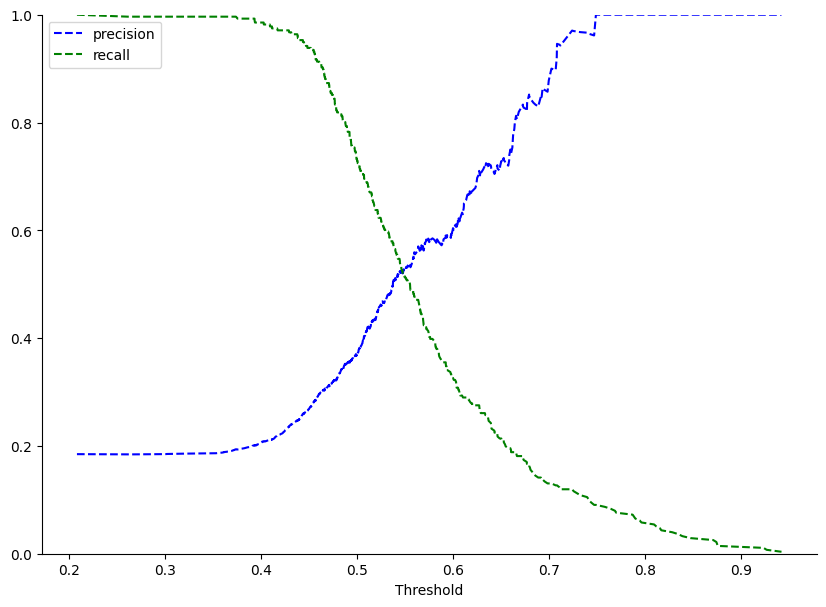

In [322]:

precisions_lg, recalls_lg, thresholds_lg = precision_recall_curve(y_test, Y_predprob1)

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize = (10, 7))

plt.plot(thresholds_lg, precisions_lg[:-1], 'b--', label = 'precision')

plt.plot(thresholds_lg, recalls_lg[:-1], 'g--', label = 'recall')

plt.xlabel('Threshold')

plt.legend(loc = 'upper left')

plt.ylim([0, 1])

plt.show()

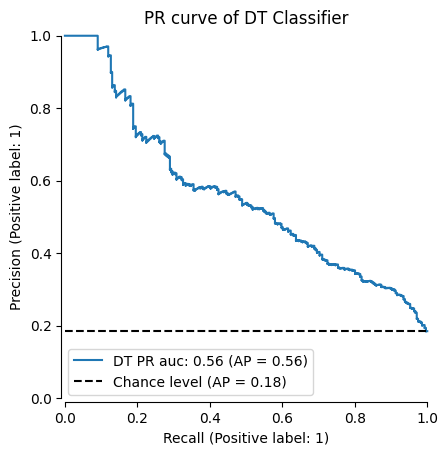

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      1218
           1       0.51      0.56      0.53       276

    accuracy                           0.82      1494
   macro avg       0.70      0.72      0.71      1494
weighted avg       0.83      0.82      0.82      1494



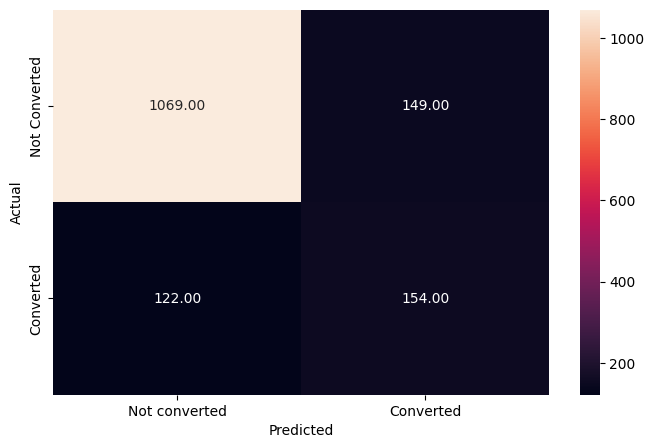

In [323]:
# set the probabity threshold 0.55 and see the results
Y_pred1 = np.where(Y_predprob1<0.54,0,1)

# PR curve plot from sklearn
precision, recall, threshold = precision_recall_curve(y_test, Y_predprob1)
pr_auc = auc(recall, precision)

# display PR curve from predictions
display = PrecisionRecallDisplay.from_predictions(
    y_test, Y_predprob1, name=f"DT PR auc: {round(pr_auc,2)}", plot_chance_level=True, despine=True
)
display.ax_.set_title("PR curve of DT Classifier")
plt.show()
metrics_score(y_test,Y_pred1)

The final results of the linear classifier at a threshold of **p = 0.54** is a recall of positive class of around **0.54**. The **auc** of the **PR** and **ROC** of the L2-model is **0.56** and **0.81** respectively.

### **Decision Tree - Hyperparameter Tuning**
For time management i decided to perform gridsearch before using the default model starting with the Decsion Tree

**Criterion {“gini”, “entropy”}**

The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” for the information gain.

**max_depth**

The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples.

**min_samples_leaf**

The minimum number of samples is required to be at a leaf node. A split point at any depth will only be considered if it leaves at least min_samples_leaf training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.

You can learn about more Hyperpapameters on this link and try to tune them.

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html


Using the parameters to the final RF classifier

In [324]:
# Choose the type of classifier
dtree_estimator = DecisionTreeClassifier(class_weight = "balanced", random_state = seed)

# Grid of parameters to choose from
parameters = {'max_depth': [None,5,7,9,11], # my initial parameters included None, 3,5,7
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf': [1,3,5,10,15] # it also included 5 and 10
             }

# Run the grid search
gridCV = GridSearchCV(dtree_estimator, parameters, scoring = score_test, cv = cv)

# Fitting the grid search on the train data
gridCV = gridCV.fit(X_train, y_train)

# Set the classifier to the best combination of parameters
dtree_estimator = gridCV.best_estimator_

# Fit the best estimator to the data
dtree_estimator.fit(X_train, y_train)

gridCV.best_params_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 10}

In [325]:
dtree_estimator

DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=10,
                       random_state=14)

0.8725860284143643
              precision    recall  f1-score   support

           0       0.94      0.83      0.88      1218
           1       0.51      0.78      0.62       276

    accuracy                           0.82      1494
   macro avg       0.73      0.80      0.75      1494
weighted avg       0.86      0.82      0.83      1494



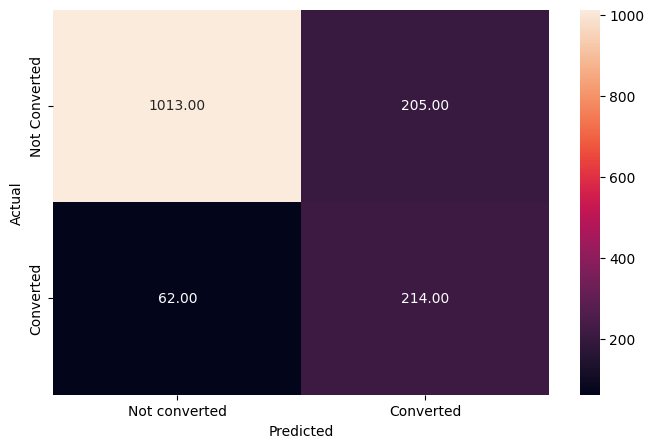

In [326]:
# compute predictions from the tree
Y_pred2 = dtree_estimator.predict(X_test)
Y_predprob2 = dtree_estimator.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, Y_predprob2))

metrics_score(y_test, Y_pred2)

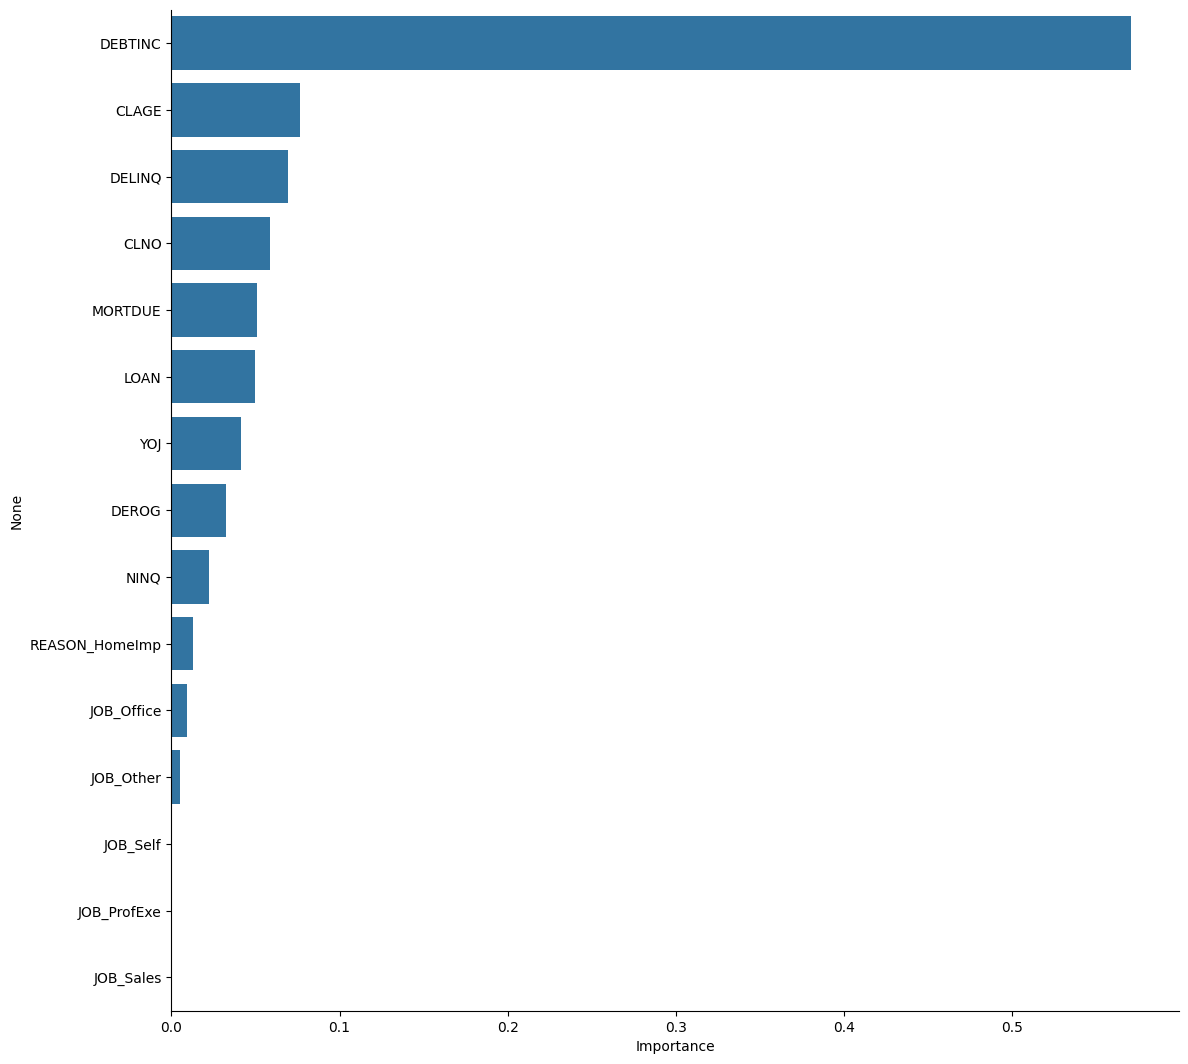

In [327]:
importances_dt = dtree_estimator.feature_importances_

columns = X_test.columns

importance_dt_df = pd.DataFrame(importances_dt, index = columns, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

sns.barplot(x= importance_dt_df.Importance, y= importance_dt_df.index);

### Observations Decision tree
During cross-validation I added the default parameters in. The tuned model shows a very good balance in recall between the two classes and an auc of **0.87** outperforming the linear model. The imporance analysis shows that DEBTINC, CLAGE, DELINQ are features that should be considered. <br>
I will proceed with the random forest, if the bagging approach will increase the recall of the positive class.

### **Building a Random Forest Classifier and Tuning it directly**

- I decided to skip the default model approach, and perform hyperparamater search for time management.
- I will test the default model if I dont have a robust classifier.
- However, after tuning the forest, the following hyperparmateters showed robust results in 10-fold CV:
  - max_features = 0.4
  - max depth = 5
  - min_samples_leaf = 10
  - n_estmators = 300 (anyhting from 200 an so on is ok)
  - class_weight = "balanced"

This results give lower precision (and accuracy) but higher recall for the positive class in comparison with a more balanced model metrics of ~0.74 and 0.78 percision/recall with the following hyperparameters (depth=9, max_feat=0.7, min_samples = 5) <br>
I chose the model with the best recall in the positive class.
It makes sennse, since by reducing the depth of the individuall trees I manage to mitigate overfitting. <br>
In this approach I will not analyze the training set - It doesnt matter.

As for feature impertance I will base my results from mean accuracy decrease via permutation first, and then mean entropy decrease from random forest built in permutation importance sceme.

In [328]:
run_cell = False
if run_cell:
  print("Running GridSearch for RF")
  # Choose the type of classifier
  rf_estimator_tuned = RandomForestClassifier(class_weight = {0: 0.2, 1: 0.8}, random_state = seed, n_jobs=6)

  # Grid of parameters to choose from
  params_rf = {
          "n_estimators": [100],
          "min_samples_leaf": [1,3,5,10,15,30],
          "max_features": [0.3,0.5, 0.7, 0.9, 'sqrt'],
          "max_depth" : [4,5,6,7,9]
  } # max depth - I leave it at default not to make things more complicated for now

  # cv fold and score already instantiated
  ?
  # Run the grid search
  grid_obj = GridSearchCV(rf_estimator_tuned, params_rf, scoring = score_test, cv = cv)

  grid_obj = grid_obj.fit(X_train, y_train)

  # Set the classifier to the best combination of parameters
  rf_estimator_tuned = grid_obj.best_estimator_
  print(grid_obj.best_params_)
else:
  print("Cell not run ths time")

Cell not run ths time


In [329]:
# grid_obj.best_params_

0.9171307203541086
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1218
           1       0.59      0.80      0.68       276

    accuracy                           0.86      1494
   macro avg       0.77      0.84      0.79      1494
weighted avg       0.88      0.86      0.87      1494



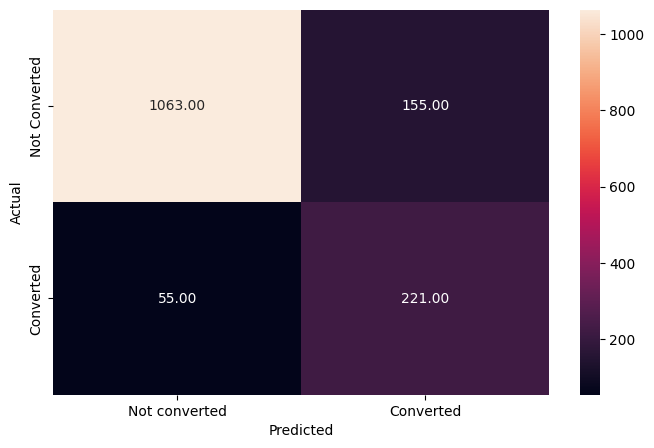

In [330]:
# build an RF estimators with pipeline
rf_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("rf", RandomForestClassifier(random_state=seed, class_weight="balanced", criterion="entropy",
                                      min_samples_leaf=10, max_features=0.4,  n_estimators=500, max_depth=5,
                                      n_jobs=6))
    ])

rf_pipe.fit(X_train, y_train)
Y_pred3 = rf_pipe.predict(X_test)
Y_predprob3 = rf_pipe.predict_proba(X_test)[:,1]


print(roc_auc_score(y_test, Y_predprob3))
metrics_score(y_test, Y_pred3)

In [331]:
# get feature importances from the model
entropy_mean = rf_pipe.named_steps["rf"].feature_importances_
entropy_std = np.std([tree.feature_importances_ for tree in rf_pipe.named_steps["rf"].estimators_], axis=0)

# get standard deviation of importances
rf_pipe.named_steps["rf"].estimators_


# permutation importance
perm_imp = permutation_importance(rf_pipe, X_test, y_test, n_repeats=10, random_state=seed, n_jobs=7)
perm_mean = perm_imp.importances_mean
perm_std = perm_imp.importances_std


In [332]:
# make a dataframe with importances
imp_df = pd.DataFrame({
    "feature": X_train.columns,
    "entropy_mean": entropy_mean,
    "entropy_std": entropy_std,
    "perm_mean": perm_mean,
    "perm_std": perm_std
})
important_features = imp_df.sort_values(by="perm_mean", ascending=False).head(6).feature.to_list()



In [333]:
imp_df.sort_values(by="perm_mean", ascending=False, inplace=True)

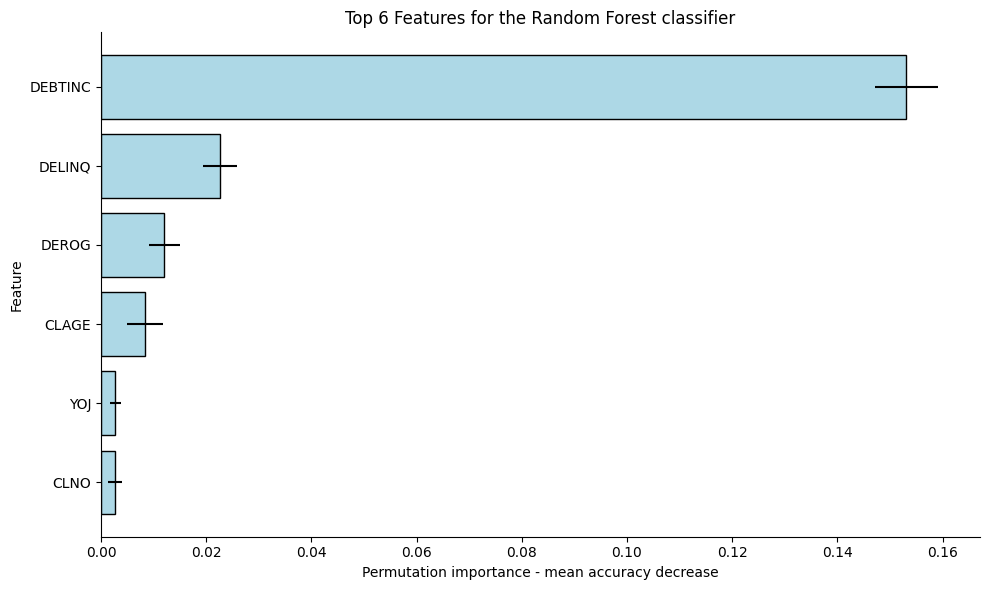

In [334]:
# Create the bar plot with error bars
fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(
    imp_df.head(6)["feature"],
    imp_df.head(6)["perm_mean"],
    xerr=imp_df.head(6)["perm_std"],
    color="lightblue",
    edgecolor="black"
)

ax.invert_yaxis()  # highest importance at the top
ax.set_xlabel("Permutation importance - mean accuracy decrease")
ax.set_ylabel("Feature")
ax.set_title("Top 6 Features for the Random Forest classifier")

plt.tight_layout()
plt.show()

## **Profiling Loan Defaults using most important Features**
- As a step further and a suggestion as a biologist , i would be really be interested to the profiles of loan defaulters.
- Stopping at the feature importance would be a crime, if that classifier is indeed that accurate.
- I will perform UMAP to the most important features and plot 2D all the client of the bank and try to identify communities and different trajectories that are hidden from the traditional EDA approaches.
- This approach requires the decision of the most important features, since a change will result to a different structre of the profiles.



In [336]:
# perform umap to final_dfc using only the omprtant features
final_dfc_imp = final_dfc[important_features]
final_dfc_imp_scaled = StandardScaler().fit_transform(final_dfc_imp)
# umap plot with parameters
reducer = umap.UMAP(random_state=seed, n_neighbors=20, min_dist=0.2, n_components=2, metric='euclidean')
umap2d = reducer.fit_transform(final_dfc_imp_scaled)

In [337]:
# concatanate the umap embeddings with the dataframe containing all the data
final_df_analysis = pd.concat([final_dfc.reset_index(drop=True),pd.DataFrame(umap2d, columns=["UMAP1", "UMAP2"])], axis=1)

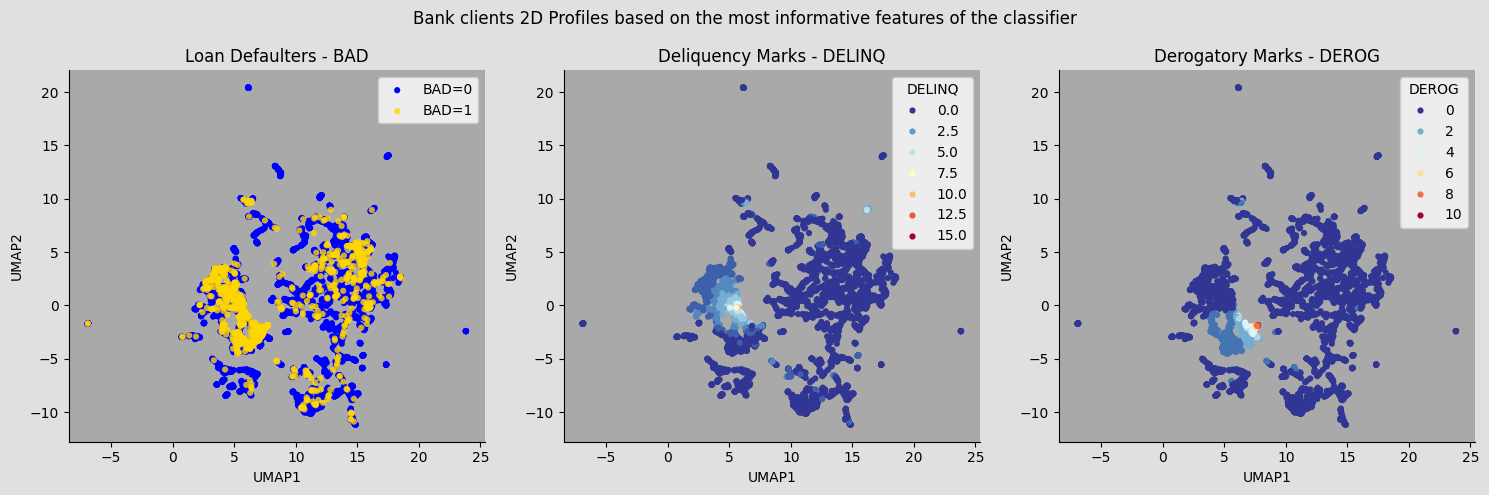

In [338]:
# plot the umap coordinates and color by BAD
# plot_frame = final_df_analysis[(final_df_analysis["DEBTINC"] < 53) & (final_df_analysis["DEROG"] > 1)]
# plot_frame = final_df_analysis[(final_df_analysis["DEBTINC"] < 53) & (final_df_analysis["DEROG"] < 1)]
# plot_frame = final_df_analysis[(final_df_analysis["DEBTINC"] < 53) & (final_df_analysis["LOAN"] < 50000) & (final_df_analysis["BAD"] ==1 )]
plot_frame = final_df_analysis[(final_df_analysis["DEBTINC"] < 53)& (final_df_analysis["LOAN"] < 50000)]
hue1 = "BAD"
hue2 = "DELINQ"
hue3 = "DEROG"
fig, axes = plt.subplots(1,3, figsize=(15, 5),facecolor="#e0e0e0")
for ax in axes:
  ax.set_facecolor("darkgray") # axes background

ax = axes[0]
for val, col, a in [(0, "blue", 1),   # only blue gets α=0.3
                    (1, "gold", 0.8)]:  # gold fully opaque
    sub = plot_frame[plot_frame[hue1] == val]
    sns.scatterplot(
        x="UMAP1", y="UMAP2",
        data=sub,
        color=col,
        alpha=a,
        s=20,
        edgecolors="none",
        linewidth=0,
        ax=ax,
        label=f"{hue1}={val}"
    )

ax.set_title(f"Loan Defaulters - {hue1}")
ax.set_xlabel("UMAP1")
ax.set_ylabel("UMAP2")
# bad = sns.scatterplot(
#     data=plot_frame,
#     x="UMAP1",
#     y="UMAP2",
#     hue=hue1,
#     # palette="RdYlBu",
#     palette={0: "blue", 1: "gold"},
#     alpha=0.7,
#     s=20,
#     edgecolor = None,
#     linewidth = 0,
#     ax=axes[0]
# )
# bad.set_title(f"Loan Defaulters - {hue1}")
# bad.set_xlabel("UMAP1")
# bad.set_ylabel("UMAP2")


second = sns.scatterplot(
    data=plot_frame,
    x="UMAP1",
    y="UMAP2",
    hue=hue2,
    palette="RdYlBu_r",
    # palette={0: "lightblue", 1: "gold"},
    alpha=1,
    s=20,
    edgecolors="none",
    linewidth=0,
    ax=axes[1]
)

second.set_title(f"Deliquency Marks - {hue2}")
second.set_xlabel("UMAP1")
second.set_ylabel("UMAP2")

third = sns.scatterplot(
    data=plot_frame,
    x="UMAP1",
    y="UMAP2",
    hue=hue3,
    palette="RdYlBu_r",
    # palette={0: "lightblue", 1: "gold"},
    alpha=1,
    s=20,
    edgecolors="none",
    linewidth=0,
    ax=axes[2]
)

third.set_title(f"Derogatory Marks - {hue3}")
third.set_xlabel("UMAP1")
third.set_ylabel("UMAP2")

plt.suptitle("Bank clients 2D Profiles based on the most informative features of the classifier")
# ax.legend(title="Years on Job", loc="best")
plt.tight_layout()
# save plot
plt.savefig("umap_loan_defaulters.png")
plt.show()


Profiling shows interesting results. We have some well defined clustered of loan defaluters. However, it shows two different tendencies in respect to DEROG and DELINQ, which is indicative of how the bank handles the defaulters or how those that are close to defaulting are trying to not get a DEROG mark. <br>
There is another dispersed group shich, although has defaulted, has no DEROG/DELINQ marks from the Bank, and no record whatsoever.<br>
WHO ARE THEY?

I made dash app for further exploration, comment it out for now...

In [339]:
# import dash
# from dash import dcc, html, Input, Output
# import pandas as pd
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots

# # ——— Load / prepare your data ———
# df = final_df_analysis.query("DEBTINC < 53 & LOAN < 50000").copy()

# # ——— Configuration ———
# VARIABLES   = ["DELINQ", "DEROG", "DEBTINC", "LOAN", "VALUE", "YOJ", "CLAGE"]
# BAD_COLORS  = {0: "blue", 1: "gold"}
# FIG_WIDTH   = 1000    # fixed figure width
# FIG_HEIGHT  = 500     # fixed figure height

# # ——— Build the Dash app ———
# app = dash.Dash(__name__)

# app.layout = html.Div(style={"backgroundColor": "#e0e0e0","padding":20}, children=[
#     # Controls row
#     html.Div(style={"display":"flex", "gap":"2rem","marginBottom":"1rem"}, children=[
#         html.Div([
#             html.Label("Filter BAD:"),
#             dcc.Dropdown(
#                 id="bad-filter",
#                 options=[
#                     {"label":"Both",    "value":"both"},
#                     {"label":"Non-Defaulter", "value":0},
#                     {"label":"Defaulter", "value":1},
#                 ],
#                 value="both", clearable=False, style={"width":"150px"}
#             )
#         ]),
#         html.Div([
#             html.Label("Left Color Variable:"),
#             dcc.Dropdown(
#                 id="var-dropdown",
#                 options=[{"label":v,"value":v} for v in VARIABLES],
#                 value="DELINQ", clearable=False, style={"width":"200px"}
#             )
#         ]),
#         html.Div(style={"flex":"1 1 auto"}, children=[
#             html.Label("Color‑scale range (deciles):"),
#             dcc.RangeSlider(
#                 id="var-range",
#                 min=0, max=1, step=0.2, value=[0,1],
#                 marks={i/10: str(i*10)+"%" for i in range(11)},
#                 tooltip={"placement":"bottom","always_visible":True}
#             )
#         ]),
#     ]),
#     # Graph with fixed size
#     dcc.Graph(
#         id="umap-fig",
#         style={"width": f"{FIG_WIDTH}px", "height": f"{FIG_HEIGHT}px"},
#         config={"responsive": False}
#     ),
# ])

# # ——— Update the slider whenever you pick a new variable ———
# @app.callback(
#     Output('var-range','min'),
#     Output('var-range','max'),
#     Output('var-range','value'),
#     Output('var-range','step'),
#     Output('var-range','marks'),
#     Input('var-dropdown','value'),
# )
# def update_range_slider(var):
#     series    = df[var].dropna()
#     deciles   = series.quantile([i/10 for i in range(11)]).to_list()
#     vmin,vmax = float(deciles[0]), float(deciles[-1])
#     step      = (vmax-vmin)/100 if vmax>vmin else 1
#     marks     = {d: f"{d:.2f}" for d in deciles}
#     return vmin, vmax, [vmin,vmax], step, marks

# # ——— Redraw UMAP on any control change ———
# @app.callback(
#     Output("umap-fig","figure"),
#     Input("bad-filter","value"),
#     Input("var-dropdown","value"),
#     Input("var-range","value"),
# )
# def update_umap(bad_filter, left_var, var_range):
#     # 1) subset
#     if bad_filter in (0,1):
#         dff = df[df["BAD"]==bad_filter]
#     else:
#         dff = df

#     # 2) two‐panel figure
#     fig = make_subplots(
#         rows=1, cols=2,
#         subplot_titles=("Profile by Loan Default", f" Profile by {left_var}"),
#         horizontal_spacing=0.08
#     )

#     # Left: continuous‐color scatter
#     fig.add_trace(
#         go.Scatter(
#             x=dff["UMAP1"], y=dff["UMAP2"],
#             mode="markers",
#             marker=dict(
#                 color=dff[left_var],
#                 colorscale="RdYlBu",
#                 cmin=var_range[0], cmax=var_range[1],
#                 colorbar=dict(title=left_var),
#                 showscale=True
#             ),
#             showlegend=False
#         ), row=1, col=2
#     )

#     # Right: two traces, one per BAD
#     for b_val,col in BAD_COLORS.items():
#         dd = dff[dff["BAD"]==b_val]
#         fig.add_trace(
#             go.Scatter(
#                 x=dd["UMAP1"], y=dd["UMAP2"],
#                 mode="markers",
#                 marker=dict(color=col),
#                 name=f"BAD={b_val}"
#             ), row=1, col=1
#         )

#     # 3) styling
#     fig.update_layout(
#         paper_bgcolor="#e0e0e0",
#         plot_bgcolor="darkgray",
#         width=FIG_WIDTH,
#         height=FIG_HEIGHT,
#         margin=dict(l=40,r=40,t=80,b=40),
#         title_text="Interactive Profile Analysis of Bank clients",
#         title_x=0.5,
#         # LEGEND positioned top‐right
#         legend=dict(
#             x=0.12,
#             y=0.98,
#             xanchor="right",
#             yanchor="top",
#             bgcolor="rgba(255,255,255,0.5)"
#         )
#     )

#     # no grid‐lines
#     for c in (1,2):
#         fig.update_xaxes(showgrid=False, row=1, col=c)
#         fig.update_yaxes(showgrid=False, row=1, col=c)

#     return fig

# if __name__ == "__main__":
#     app.run(debug=True)

In [340]:
import dash
from dash import dcc, html, Input, Output
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# ——— Load / prepare your data ———
df = final_df_analysis.query("DEBTINC < 53 & LOAN < 50000").copy()

# ——— Configuration ———
VARIABLES   = ["DELINQ", "DEROG", "DEBTINC", "LOAN", "VALUE", "YOJ", "CLAGE", "MORTDUE", "NINQ", "CLNO"]
BAD_COLORS  = {0: "blue", 1: "gold"}
FIG_WIDTH   = 1400
FIG_HEIGHT  = 600
# ——— Build the Dash app ———
app = dash.Dash(__name__)

def make_var_dropdown(drop_id, label, default):
    return html.Div([
        html.Label(label),
        dcc.Dropdown(
            id=drop_id,
            options=[{"label": v, "value": v} for v in VARIABLES],
            value=default,
            clearable=False,
            style={"width": "200px"},
        ),
    ])

def make_range_slider(slider_id):
    return html.Div([
        html.Label("Color‑scale range (deciles):"),
        dcc.RangeSlider(
            id=slider_id,
            min=0, max=1, step=0.2, value=[0, 1],  # placeholders, overwritten by callback
            marks={i/10: f"{i*10}%" for i in range(11)},
            tooltip={"placement": "bottom", "always_visible": True},
        ),
    ],
    style={
        "flex": "none",                             # change here the width
        "width": f"{FIG_WIDTH-700}px"
    })

app.layout = html.Div(
    style={"backgroundColor": "#e0e0e0", "padding": 20},
    children=[
        # — Row 1: Filter Loan Default —
        html.Div(
            style={"display": "flex", "gap": "2rem", "marginBottom": "2rem"},
            children=[
                html.Div([
                    html.Label("Filter Loan Default:"),
                    dcc.Dropdown(
                        id="bad-filter",
                        options=[
                            {"label": "Both",          "value": "both"},
                            {"label": "Non‑Defaulter", "value": 0},
                            {"label": "Defaulter",     "value": 1},
                        ],
                        value="both",
                        clearable=False,
                        style={"width": "150px"},
                    ),
                ]),
            ],
        ),

        # — Row 2: Feature #1 + its slider —
        html.Div(
            style={
                "display": "flex",
                "gap": "2rem",
                "alignItems": "center",
                "marginBottom": "2rem",
            },
            children=[
                make_var_dropdown("var1-dropdown", "Feature #1 (centre plot):", "DELINQ"),
                make_range_slider("var1-range"),
            ],
        ),

        # — Row 3: Feature #2 + its slider —
        html.Div(
            style={
                "display": "flex",
                "gap": "2rem",
                "alignItems": "center",
                "marginBottom": "2rem",
            },
            children=[
                make_var_dropdown("var2-dropdown", "Feature #2 (right plot):", "VALUE"),
                make_range_slider("var2-range"),
            ],
        ),

        # — Graph (responsive scaling) —
        dcc.Graph(
            id="umap-fig",
            style={"width": "100%", "height": f"{FIG_HEIGHT}px"},
            config={"responsive": True},
        ),
    ],
)

def _slider_settings(series: pd.Series):
    deciles = series.quantile([i/10 for i in range(11)]).to_list()
    vmin, vmax = float(deciles[0]), float(deciles[-1])
    step = (vmax - vmin) / 100 if vmax > vmin else 1
    marks = {d: f"{d:.2f}" for d in deciles}
    return vmin, vmax, [vmin, vmax], step, marks

# ——— Slider callbacks ———
@app.callback(
    Output("var1-range", "min"),
    Output("var1-range", "max"),
    Output("var1-range", "value"),
    Output("var1-range", "step"),
    Output("var1-range", "marks"),
    Input("var1-dropdown", "value"),
)
def update_range_slider_1(var):
    return _slider_settings(df[var].dropna())

@app.callback(
    Output("var2-range", "min"),
    Output("var2-range", "max"),
    Output("var2-range", "value"),
    Output("var2-range", "step"),
    Output("var2-range", "marks"),
    Input("var2-dropdown", "value"),
)
def update_range_slider_2(var):
    return _slider_settings(df[var].dropna())

# ——— Main plotting callback ———
@app.callback(
    Output("umap-fig", "figure"),
    Input("bad-filter",    "value"),
    Input("var1-dropdown", "value"),
    Input("var1-range",    "value"),
    Input("var2-dropdown", "value"),
    Input("var2-range",    "value"),
)
def update_umap(bad_filter, var1, var1_range, var2, var2_range):
    dff = df if bad_filter == "both" else df[df["BAD"] == bad_filter]

    fig = make_subplots(
        rows=1, cols=3,
        subplot_titles=(
            "Profile by Loan Default",
            f"Profile by {var1}",
            f"Profile by {var2}"
        ),
        horizontal_spacing=0.06,
    )

    dom2 = fig.layout.xaxis2.domain
    dom3 = fig.layout.xaxis3.domain

    # — centre: colour by var1 —
    fig.add_trace(
        go.Scatter(
            x=dff["UMAP1"], y=dff["UMAP2"],
            mode="markers",
            marker=dict(
                color=dff[var1],
                colorscale="RdYlBu_r",
                cmin=var1_range[0], cmax=var1_range[1],
                showscale=True,
                colorbar=dict(
                    title=var1,
                    orientation="h",
                    x=(dom2[0] + dom2[1]) / 2,
                    y=-0.2,
                    len=dom2[1] - dom2[0],
                    yanchor="top"
                )
            ),
            showlegend=False,
        ), row=1, col=2
    )

    # — right: colour by var2 —
    fig.add_trace(
        go.Scatter(
            x=dff["UMAP1"], y=dff["UMAP2"],
            mode="markers",
            marker=dict(
                color=dff[var2],
                colorscale="RdYlBu_r",
                cmin=var2_range[0], cmax=var2_range[1],
                showscale=True,
                colorbar=dict(
                    title=var2,
                    orientation="h",
                    x=(dom3[0] + dom3[1]) / 2,
                    y=-0.2,
                    len=dom3[1] - dom3[0],
                    yanchor="top"
                )
            ),
            showlegend=False,
        ), row=1, col=3
    )

    # — left: BAD vs GOOD —
    for b_val, col in BAD_COLORS.items():
        dd = dff[dff["BAD"] == b_val]
        fig.add_trace(
            go.Scatter(
                x=dd["UMAP1"], y=dd["UMAP2"],
                mode="markers",
                marker=dict(color=col),
                name=f"BAD={b_val}",
            ), row=1, col=1
        )

    fig.update_layout(
        autosize=True,                  # Plotly autosize within container
        width=FIG_WIDTH,                # initial width
        height=FIG_HEIGHT,              # initial height
        paper_bgcolor="#e0e0e0",
        plot_bgcolor="darkgray",
        margin=dict(l=40, r=40, t=80, b=80),
        title_text="Bank clients 2D Profiles based on the most informative features of the classifier",
        title_x=0.5,
        legend=dict(
            x=0.12, y=0.98, xanchor="right", yanchor="top",
            bgcolor="rgba(255,255,255,0.5)"
        )
    )

    for c in (1, 2, 3):
        fig.update_xaxes(showgrid=False, row=1, col=c)
        fig.update_yaxes(showgrid=False, row=1, col=c)

    return fig

if __name__ == "__main__":
    app.run(debug=True)

<IPython.core.display.Javascript object>

**1. Comparison of various techniques and their relative performance based on chosen Metric (Measure of success):**
- The random forest is the best model so far, and the important features generate very interested profiles, which i wish to further explore.
- The measure of success should be recall and then ROC auc. The validation of feature importance with two different strategies is crucial for profile generation.

**2. Refined insights:**
- It seems that the defined loan defaulter cluster is driven by the DEROG and DLINQ variables. Although they overlapp, there are still many defaulters who never recieved a derogatory mark but more than enough delinquency marks. Normally after multipl deliquency marks the defaulter might receive a derogatory but it is not always the case. Maybe the bank handles some of the issues internally prior the default.
- As for the second aggregation on top right of the profile analyisis, further exploration into the dash up showed that the combination of some variables (YOJ, CLAGE, CLNO) might be responsible for this profile of defaulters who show no credit marks.


**3. Proposal for the final solution design:**
- Possibly the incorporation of more nin-linear classifiers and ensemble of heterogenous classification systems will result in better classifiaction performance.
- Better data management tacticts for the important features such as DEBTINC, DEROG, DELINQ.. etc.
- A meticulous analysis of the UMAP based profiles might shed some light to the banks's management Practises. Espesially for the dispersed cluster of loan defaulters.
- Investigation of the missing records and better data management practices.
- The bank should explain if it handles internally some cases where deliquency but no derogatory marks are observed, since the model is not aware of such cases.
- Expand the information retrieval to age, more professions, political and marital status.